# Model Intrepretation

**Context**

An international e-commerce company based wants to discover key insights from their customer database. They want to use some of the most advanced machine learning techniques to study their customers. The company sells electronic products.

**Link to the Data Set**: [kaggle-dataset](https://https://www.kaggle.com/datasets/prachi13/customer-analytics)

**Content**

The dataset used for model building contained 10999 observations of 12 variables.
The data contains the following information:

**ID**: ID Number of Customers.

**Warehouse block**: The Company have big Warehouse which is divided in to block such as A,B,C,D,E.

**Mode of shipment**:The Company Ships the products in multiple way such as Ship, Flight and Road.

**Customer care calls**: The number of calls made from enquiry for enquiry of the shipment.

**Customer rating**: The company has rated from every customer. 1 is the lowest (Worst), 5 is the highest (Best).

**Cost of the product**: Cost of the Product in US Dollars.

**Prior purchases**: The Number of Prior Purchase.

**Product importance**: The company has categorized the product in the various parameter such as low, medium, high.

**Gender**: Male and Female.

**Discount offered**: Discount offered on that specific product.

**Weight in gms**: It is the weight in grams.

**Reached on time**: It is the target variable, where 1 Indicates that the product has NOT reached on time and 0 indicates it has reached on time.

**Summary**: The dataset is consistent, with no missing values or outliers.

# **Abstract**
In this assignment we run shap analysis on models Logistic regression, random forests and Auto ML best model and describe feature importance of predictors on the model output

In [3]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 8.5 MB/s eta 0:00:00


## Logistic Regression

In [111]:
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [113]:
# Reading the data from the file
data = pd.read_csv('https://raw.githubusercontent.com/chelpuri/datascience/main/Train.csv')
data

ID Warehouse_block Mode_of_Shipment  Customer_care_calls  \
0          1               D           Flight                    4   
1          2               F           Flight                    4   
2          3               A           Flight                    2   
3          4               B           Flight                    3   
4          5               C           Flight                    2   
...      ...             ...              ...                  ...   
10994  10995               A             Ship                    4   
10995  10996               B             Ship                    4   
10996  10997               C             Ship                    5   
10997  10998               F             Ship                    5   
10998  10999               D             Ship                    2   

       Customer_rating  Cost_of_the_Product  Prior_purchases  \
0                    2                  177                3   
1                    5                  216                2   
2                    2                  183                4   
3                    3                  176                4   
4                    2                  184                3   
...                ...                  ...              ...   
10994                1                  252                5   
10995                1                  232                5   
10996                4                  242                5   
10997                2                  223                6   
10998                5                  155                5   

      Product_importance Gender  Discount_offered  Weight_in_gms  \
0                    low      F                44           1233   
1                    low      M                59           3088   
2                    low      M                48           3374   
3                 medium      M                10           1177   
4                 medium      F                46           2484   
...                  ...    ...               ...            ...   
10994             medium      F                 1           1538   
10995             medium      F                 6           1247   
10996                low      F                 4           1155   
10997             medium      M                 2           1210   
10998                low      F                 6           1639   

       Reached.on.Time_Y.N  
0                        1  
1                        1  
2                        1  
3                        1  
4                        1  
...                    ...  
10994                    1  
10995                    0  
10996                    0  
10997                    0  
10998                    0  

[10999 rows x 12 columns]

In [114]:
# dropping ID column as it is just unique value representing data.
data = data.drop("ID", 1)
#adding dummy data to categorical_columns to include additional predictor varibles
data = pd.get_dummies(data)
X = data[[ 'Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms', 'Warehouse_block_A', 'Warehouse_block_B', 'Warehouse_block_C', 'Warehouse_block_D', 'Mode_of_Shipment_Flight', 'Mode_of_Shipment_Road', 'Product_importance_high', 'Product_importance_low', 'Gender_F']]
y = data['Reached.on.Time_Y.N']

#Spliting data into Training 70%, Test set 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [115]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
model = sm.OLS(y_train, X_train).fit()
reg = LogisticRegression()
pipeline = Pipeline([
    ('reg', reg)
])
pipeline.fit(X_train, y_train)
train_accuracy = accuracy_score(y_train, pipeline.predict(X_train))
test_accuracy = accuracy_score(y_test, pipeline.predict(X_test))
print(model.summary())
print('*********************************************************************************')
print(f"train accuracy = {round(train_accuracy, 3)}, test accuracy = {round(test_accuracy, 3)} ")
print('*********************************************************************************')
print(classification_report(y_test, pipeline.predict(X_test)))

                                 OLS Regression Results                                 
Dep. Variable:     Reached.on.Time_Y.N   R-squared (uncentered):                   0.650
Model:                             OLS   Adj. R-squared (uncentered):              0.650
Method:                  Least Squares   F-statistic:                              953.2
Date:                 Sun, 17 Mar 2024   Prob (F-statistic):                        0.00
Time:                         19:58:49   Log-Likelihood:                         -4899.9
No. Observations:                 7699   AIC:                                      9830.
Df Residuals:                     7684   BIC:                                      9934.
Df Model:                           15                                                  
Covariance Type:             nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------

In [68]:
explainer = shap.Explainer(pipeline.predict, X_train)
shap_values = explainer(X_test)

PermutationExplainer explainer: 3301it [04:15, 12.72it/s]


In [69]:
def partial_dependence_plot(feature, idx=None):
    if idx is None: # visualize all samples
        shap.plots.partial_dependence(
            feature,
            pipeline.predict,
            X_train,
            ice=False,
            model_expected_value=True,
            feature_expected_value=True)
    else: # visualize sample idx
        shap.partial_dependence_plot(
            feature,
            pipeline.predict,
            X_train,
            ice=False,
            model_expected_value=True,
            feature_expected_value=True,
            shap_values=shap_values[idx:idx+1,:])

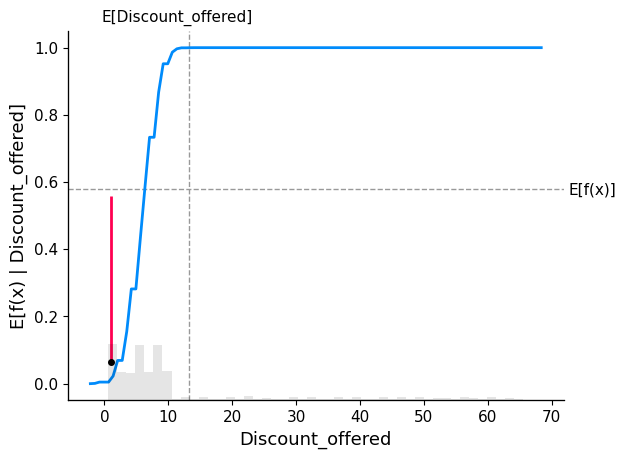

In [70]:
partial_dependence_plot('Discount_offered', 0)

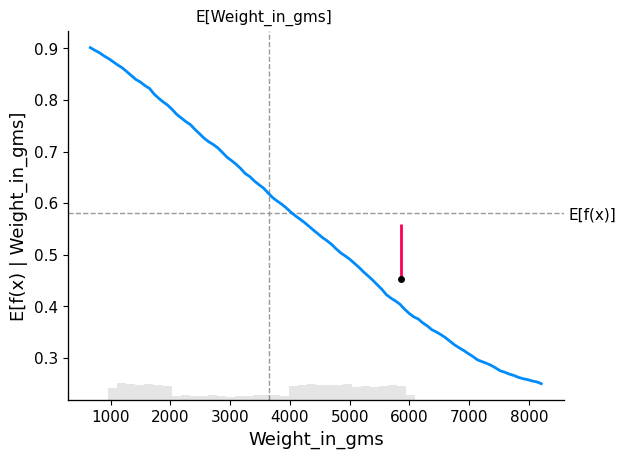

In [71]:
partial_dependence_plot('Weight_in_gms', 0)

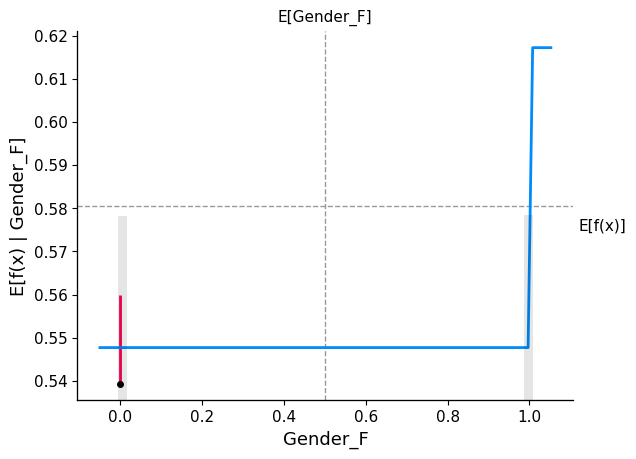

In [72]:
partial_dependence_plot('Gender_F', 0)

In [73]:
shap.initjs()

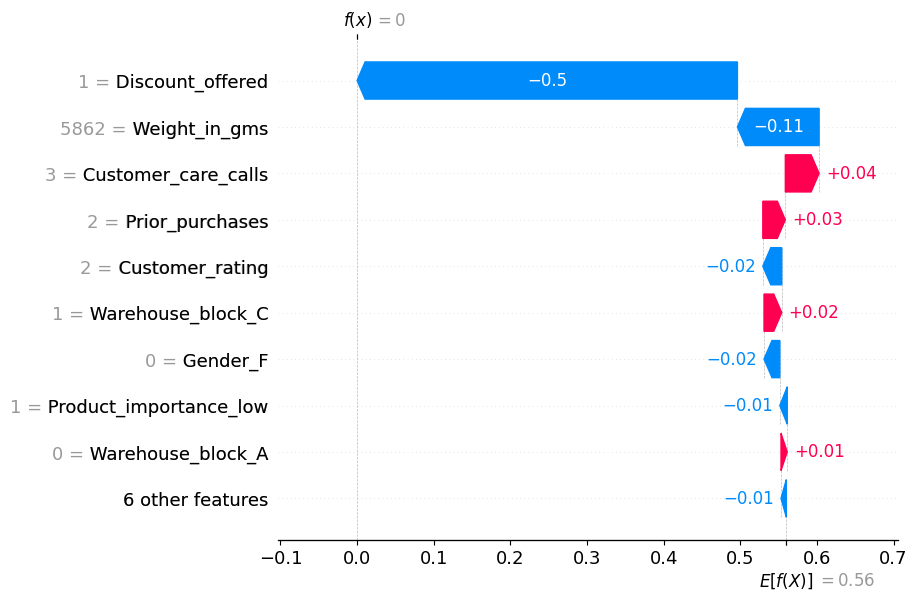

In [74]:
shap.plots.waterfall(shap_values[0])

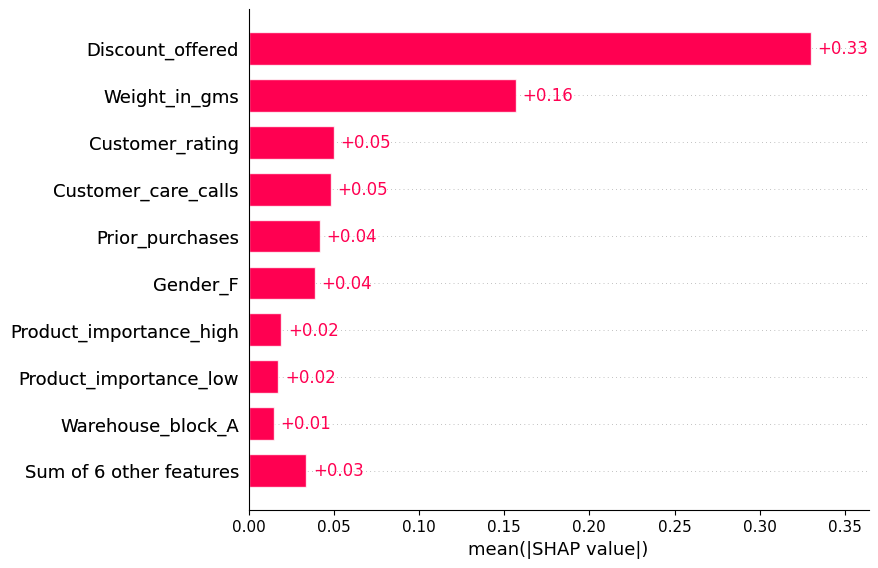

In [75]:
shap.plots.bar(shap_values)

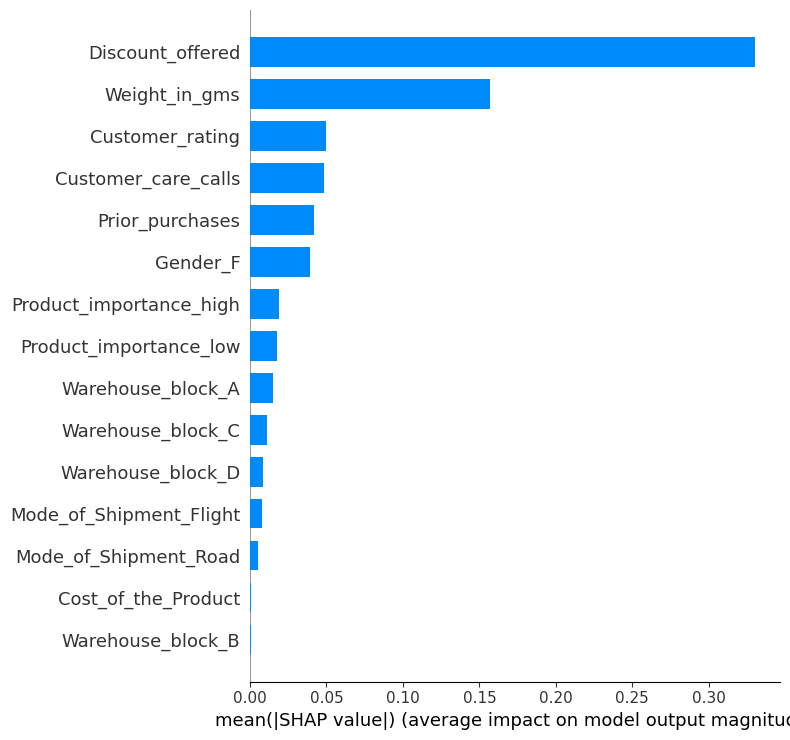

In [76]:
shap.summary_plot(shap_values.values, X_train, plot_type='bar')

The two most important features of logistic regression from SHAP analysis are Discount offered and weight in grams

## Random Forest

In [102]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
reg = RandomForestRegressor()
pipeline = Pipeline([
    ('reg', reg)
])
pipeline.fit(X_train, y_train)
train_mse = mean_squared_error(y_train, pipeline.predict(X_train))
test_mse = mean_squared_error(y_test, pipeline.predict(X_test))
print(f"train MSE = {round(train_mse, 3)}, test MSE = {round(test_mse, 3)} ")

train MSE = 0.025, test MSE = 0.266 


<BarContainer object of 15 artists>

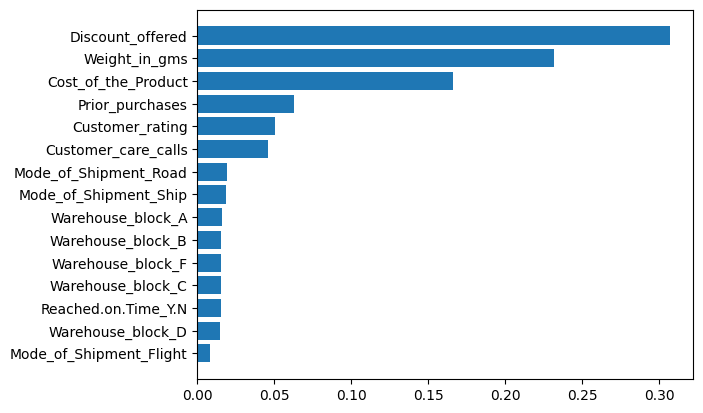

In [79]:
sorted_idx = reg.feature_importances_.argsort()
result = sorted(zip(data, reg.feature_importances_), key = lambda x: x[1], reverse=False)
plt.barh([x[0] for x in result], [x[1] for x in result])

In [80]:
explainer = shap.Explainer(pipeline.predict, X_train)
shap_values = explainer(X_test)

PermutationExplainer explainer: 1101it [09:03,  1.99it/s]


In [82]:
def partial_dependence_plot(feature, idx=None):
    if idx is None: # visualize all samples
        shap.plots.partial_dependence(
            feature,
            pipeline.predict,
            X_train,
            ice=False,
            model_expected_value=True,
            feature_expected_value=True)
    else: # visualize sample idx
        shap.partial_dependence_plot(
            feature,
            pipeline.predict,
            X_train,
            ice=False,
            model_expected_value=True,
            feature_expected_value=True,
            shap_values=shap_values[idx:idx+1,:])

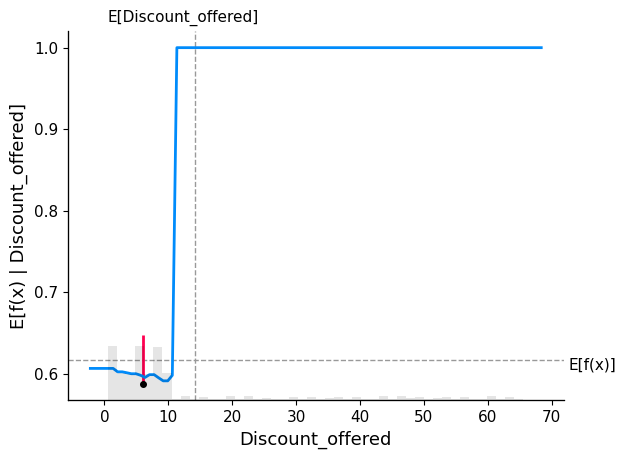

In [83]:
partial_dependence_plot('Discount_offered', 0)

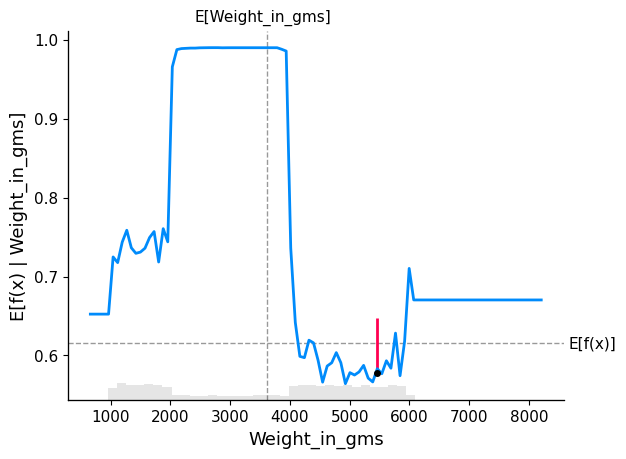

In [84]:
partial_dependence_plot('Weight_in_gms', 0)

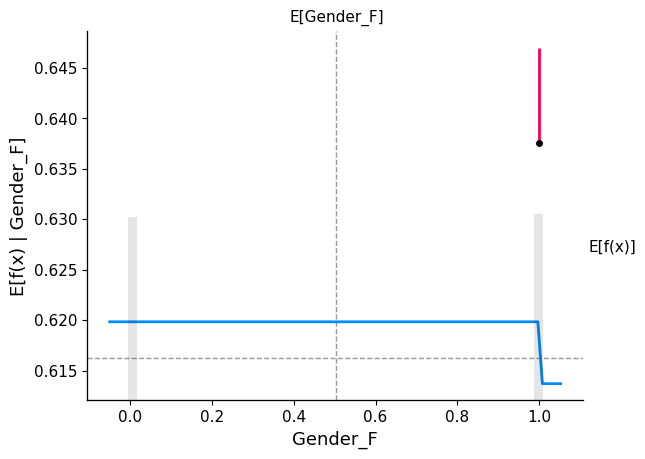

In [85]:
partial_dependence_plot('Gender_F', 0)

In [38]:
shap.initjs()

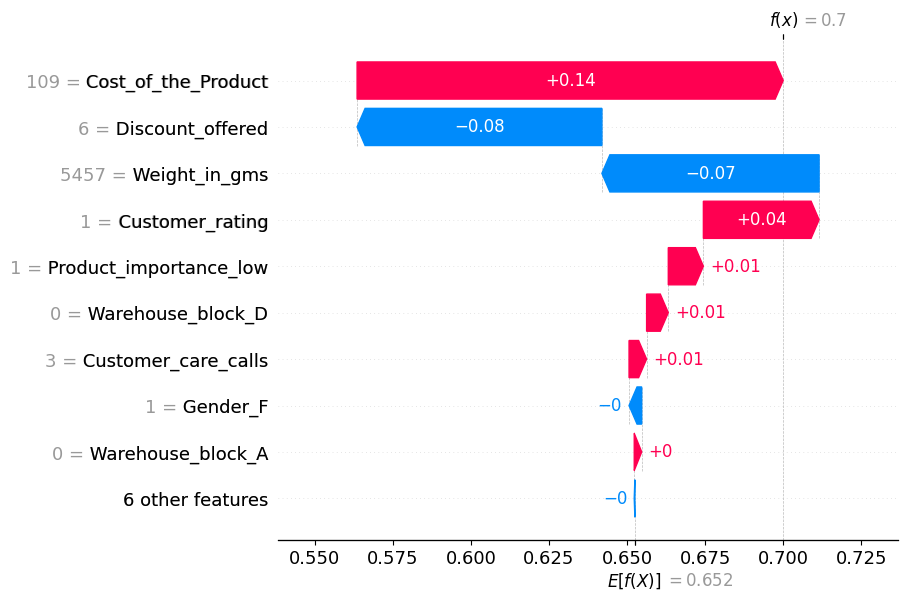

In [41]:
shap.plots.waterfall(shap_values[0])

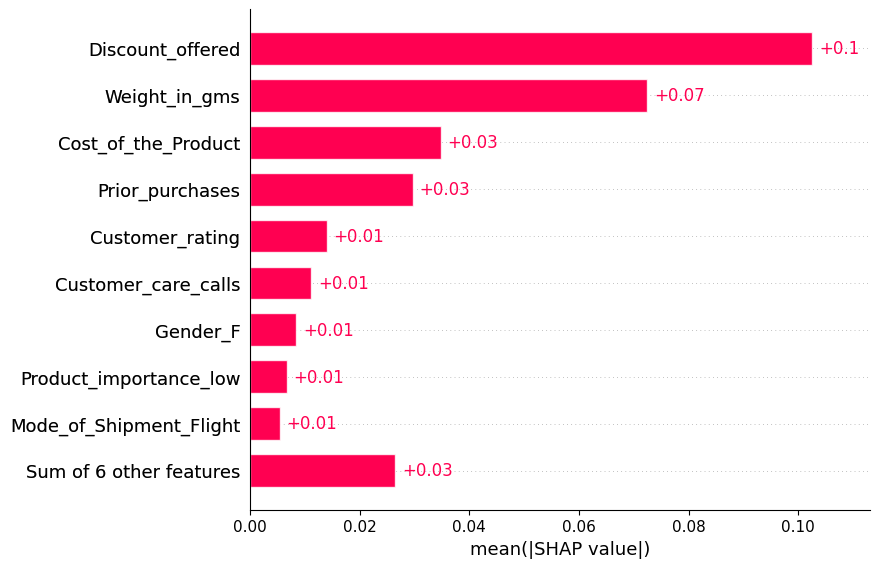

In [45]:
shap.plots.bar(shap_values)

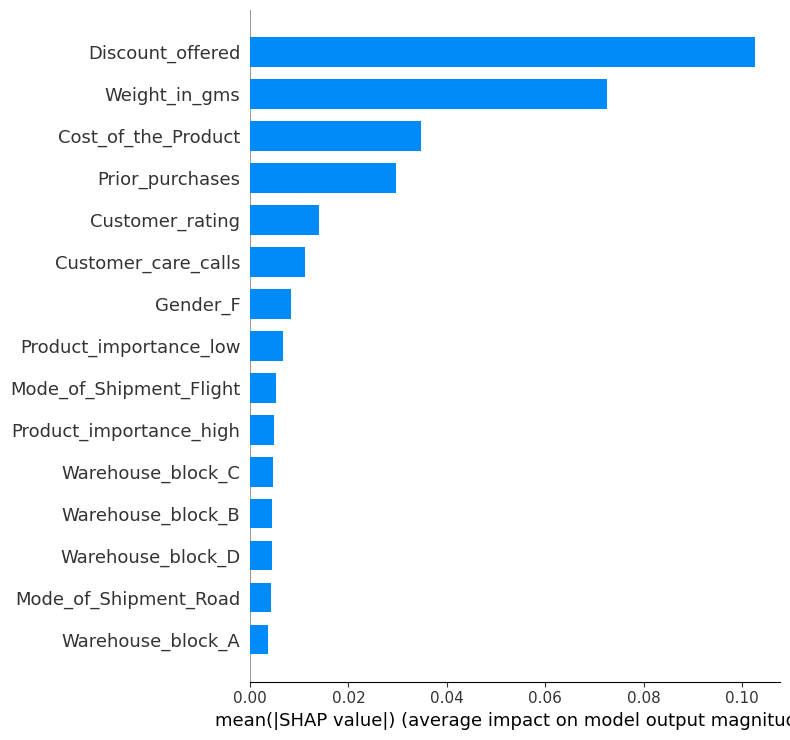

In [44]:
shap.summary_plot(shap_values.values, X_train, plot_type='bar')

The two most important features of Random forest model from SHAP analysis are Discount offered and weight in grams

## Auto ML

In [26]:
# install java
!apt-get install default-jre
!java -version
!pip install h2o

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  default-jre-headless fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libfontenc1 libxkbfile1 libxtst6 libxxf86dga1 openjdk-11-jre x11-utils
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  default-jre default-jre-headless fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libfontenc1 libxkbfile1 libxtst6 libxxf86dga1 openjdk-11-jre x11-utils
0 upgraded, 12 newly installed, 0 to remove and 38 not upgraded.
Need to get 3,720 kB of archives.
After this operation, 12.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3,042 B]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxtst6 amd64 2:1.2.3-1build4 [13.4 kB]
Get:3 http://archive.ubuntu.com

In [29]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()
h20_df = h2o.H2OFrame(data)
h20_df.types
train, test, validation = h20_df.split_frame(ratios=[.7, .15])

Checking whether there is an H2O instance running at http://localhost:54321. connected.


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         2 mins 14 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.1
H2O_cluster_version_age:    3 days
H2O_cluster_name:           H2O_from_python_unknownUser_1b9jom
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.170 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.10.12 final
--------------------------  -----------------------------------------------------------------------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [30]:
y = "Reached.on.Time_Y.N"
x = h20_df.columns
x.remove(y)
aml = H2OAutoML(max_models = 10, seed = 10, verbosity="info", nfolds=5, exclude_algos=["StackedEnsemble"])
aml.train(x = x, y = y, training_frame = train, validation_frame=validation)
lb = aml.leaderboard
lb.head()
best_model = aml.leader
best_model.model_performance(test)

AutoML progress: |
15:17:16.708: Project: AutoML_1_20240317_151716
15:17:16.710: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
15:17:16.710: Setting stopping tolerance adaptively based on the training frame: 0.011376129936896002
15:17:16.710: Build control seed: 10
15:17:16.711: training frame: Frame key: AutoML_1_20240317_151716_training_py_2_sid_8de3    cols: 20    rows: 7727  chunks: 1    size: 69425  checksum: 4382750217536373334
15:17:16.712: validation frame: Frame key: py_4_sid_8de3    cols: 20    rows: 1597  chunks: 1    size: 15437  checksum: 4382600370317699850
15:17:16.712: leaderboard frame: NULL
15:17:16.712: blending frame: NULL
15:17:16.712: response column: Reached.on.Time_Y.N
15:17:16.713: fold column: null
15:17:16.713: weights column: null
15:17:16.748: Loadi

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.175232786416369
RMSE: 0.4186081537862933
MAE: 0.35360173133588424
RMSLE: 0.2965536566817847
Mean Residual Deviance: 0.175232786416369

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

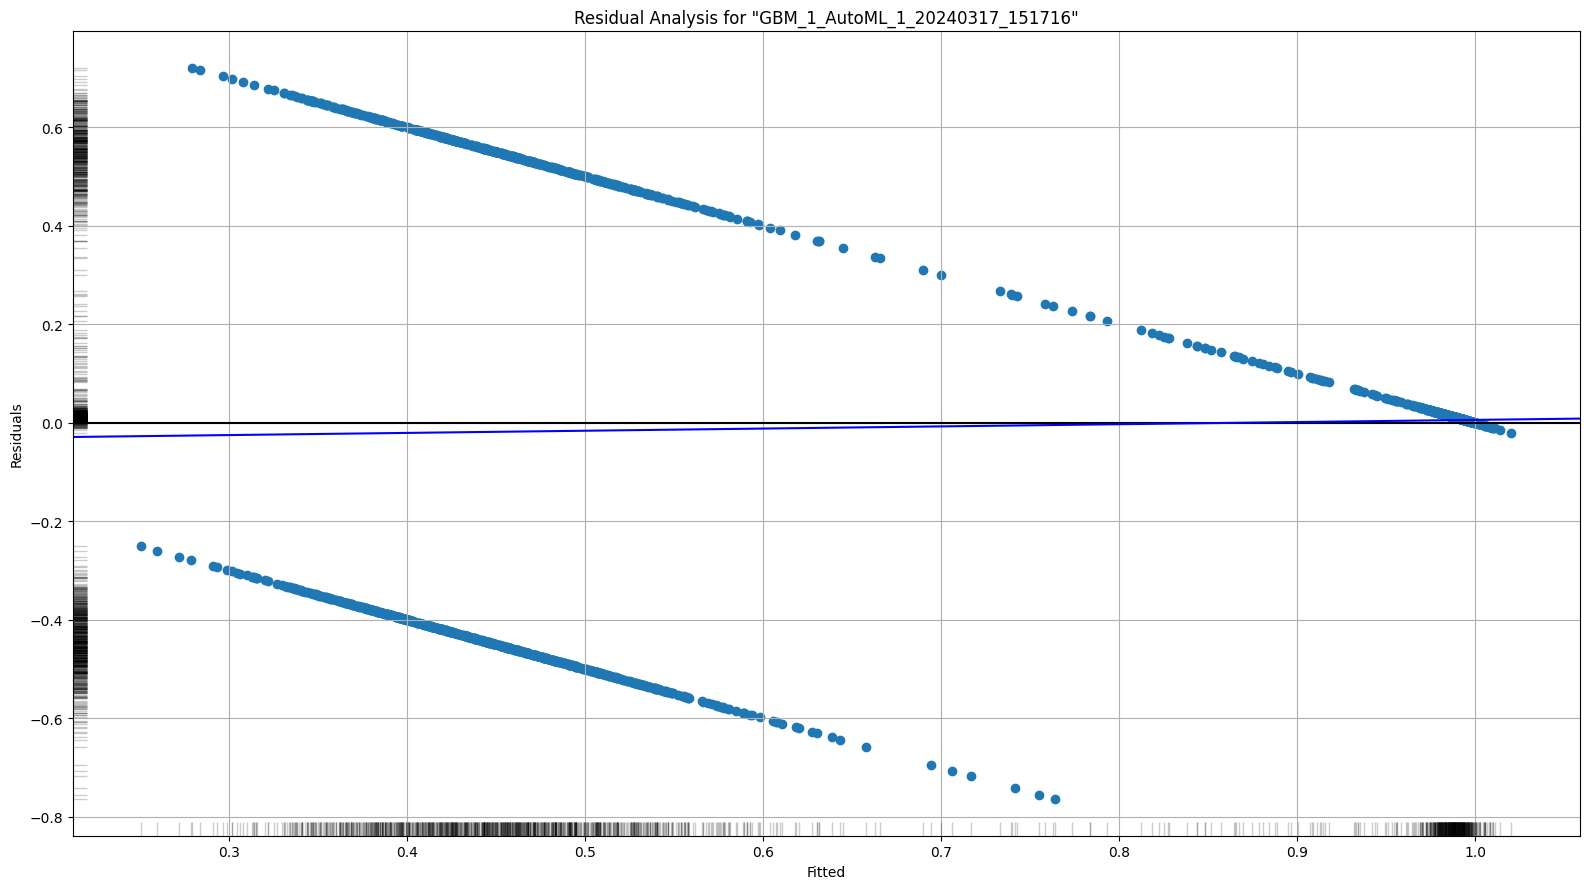

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

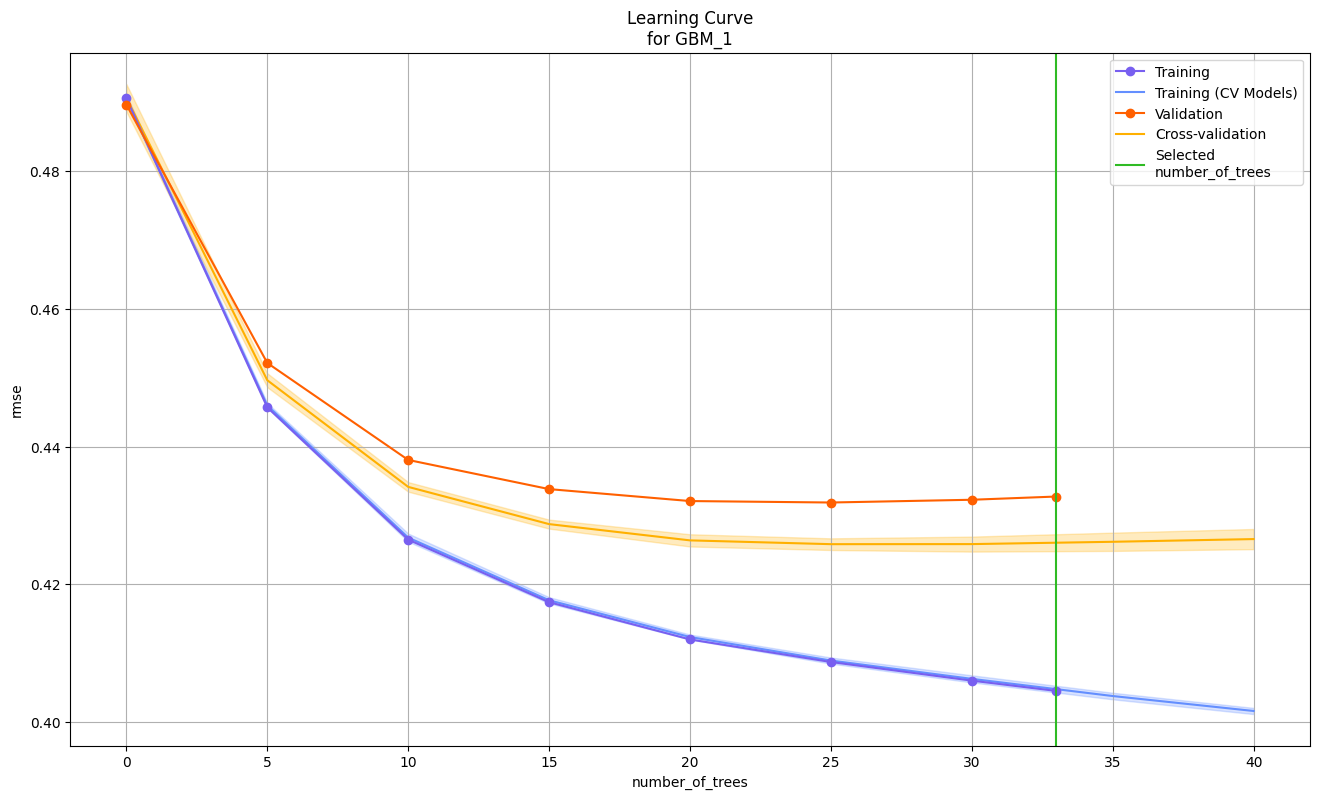

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

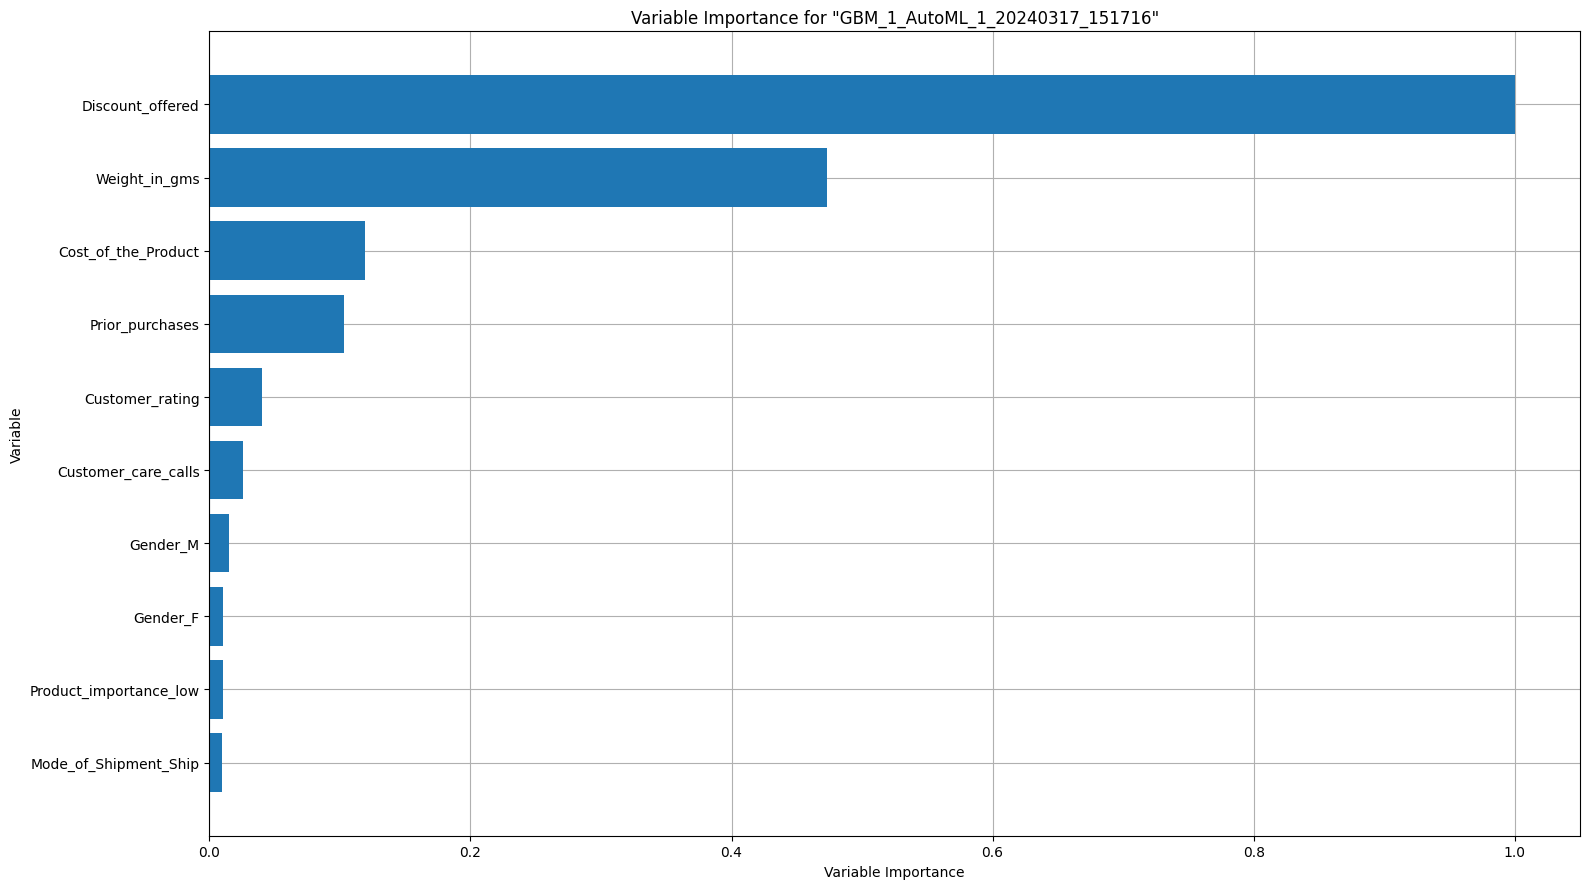

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

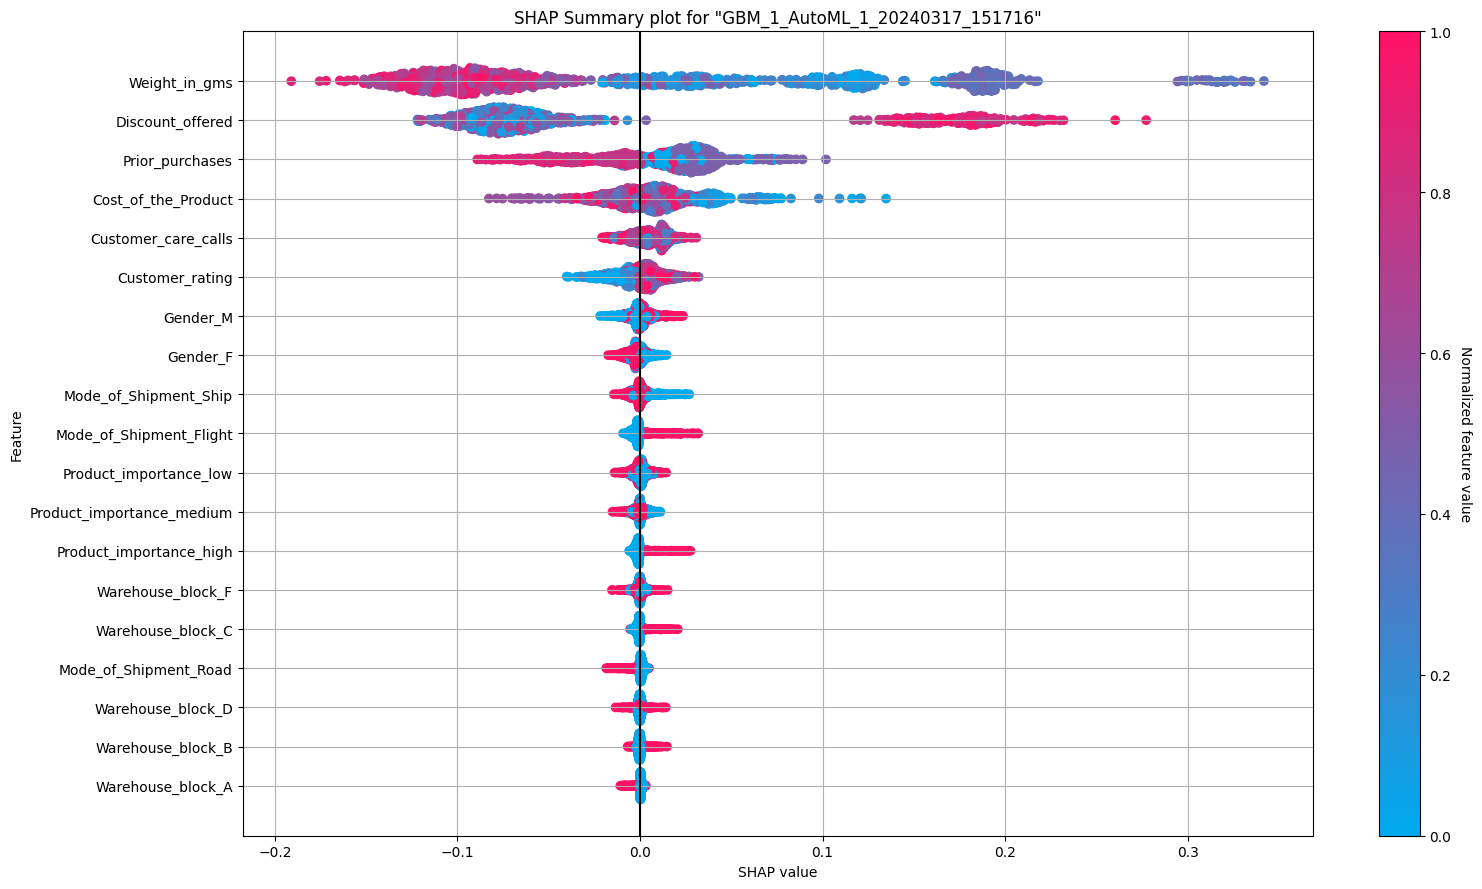

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

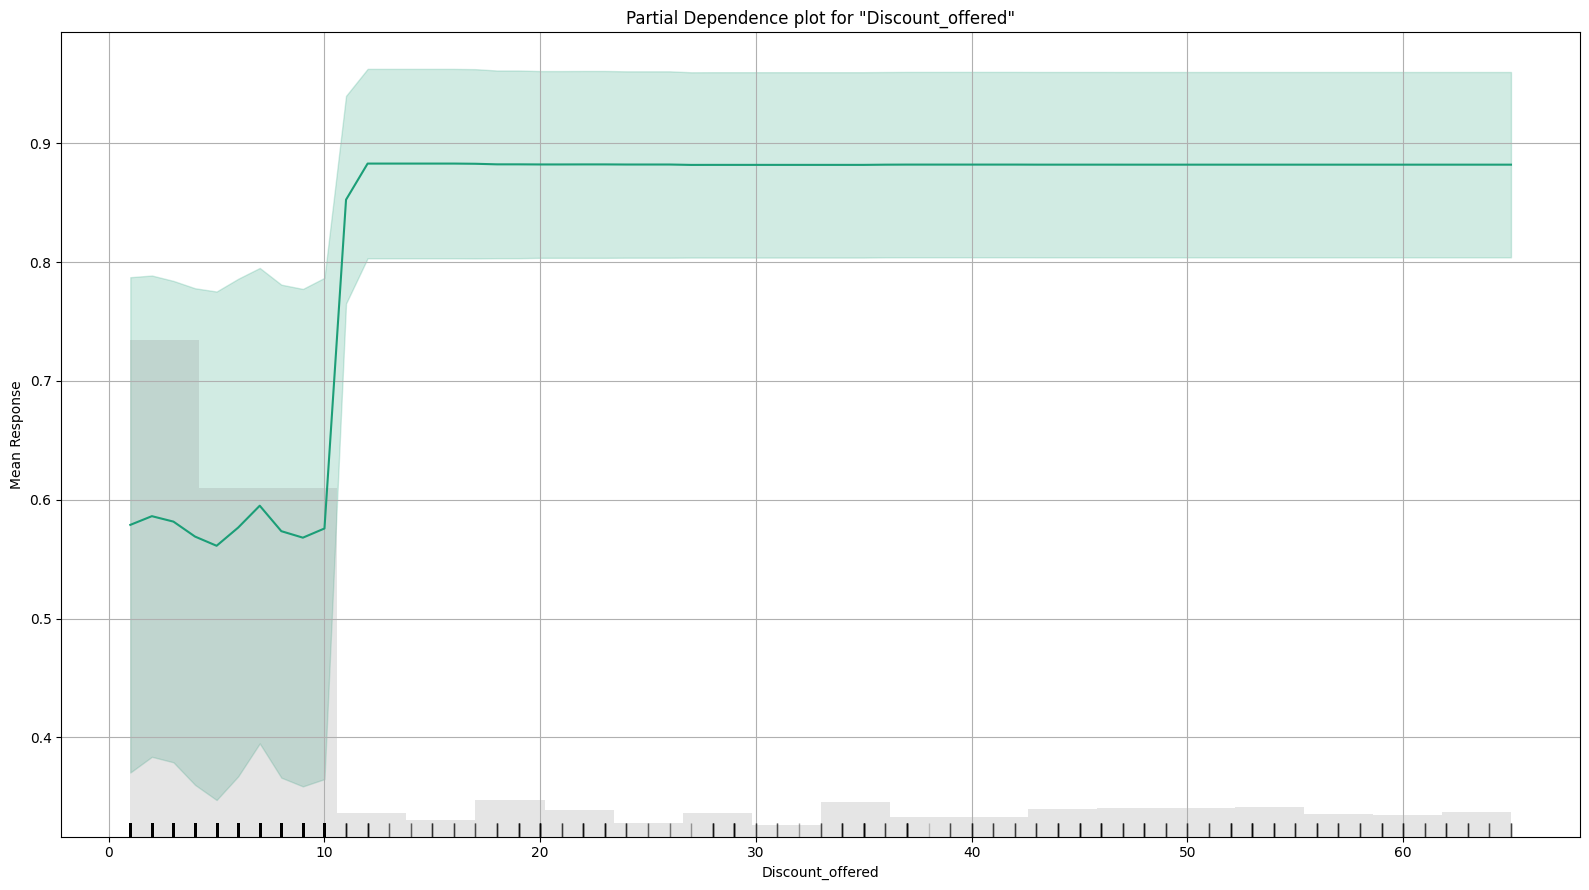

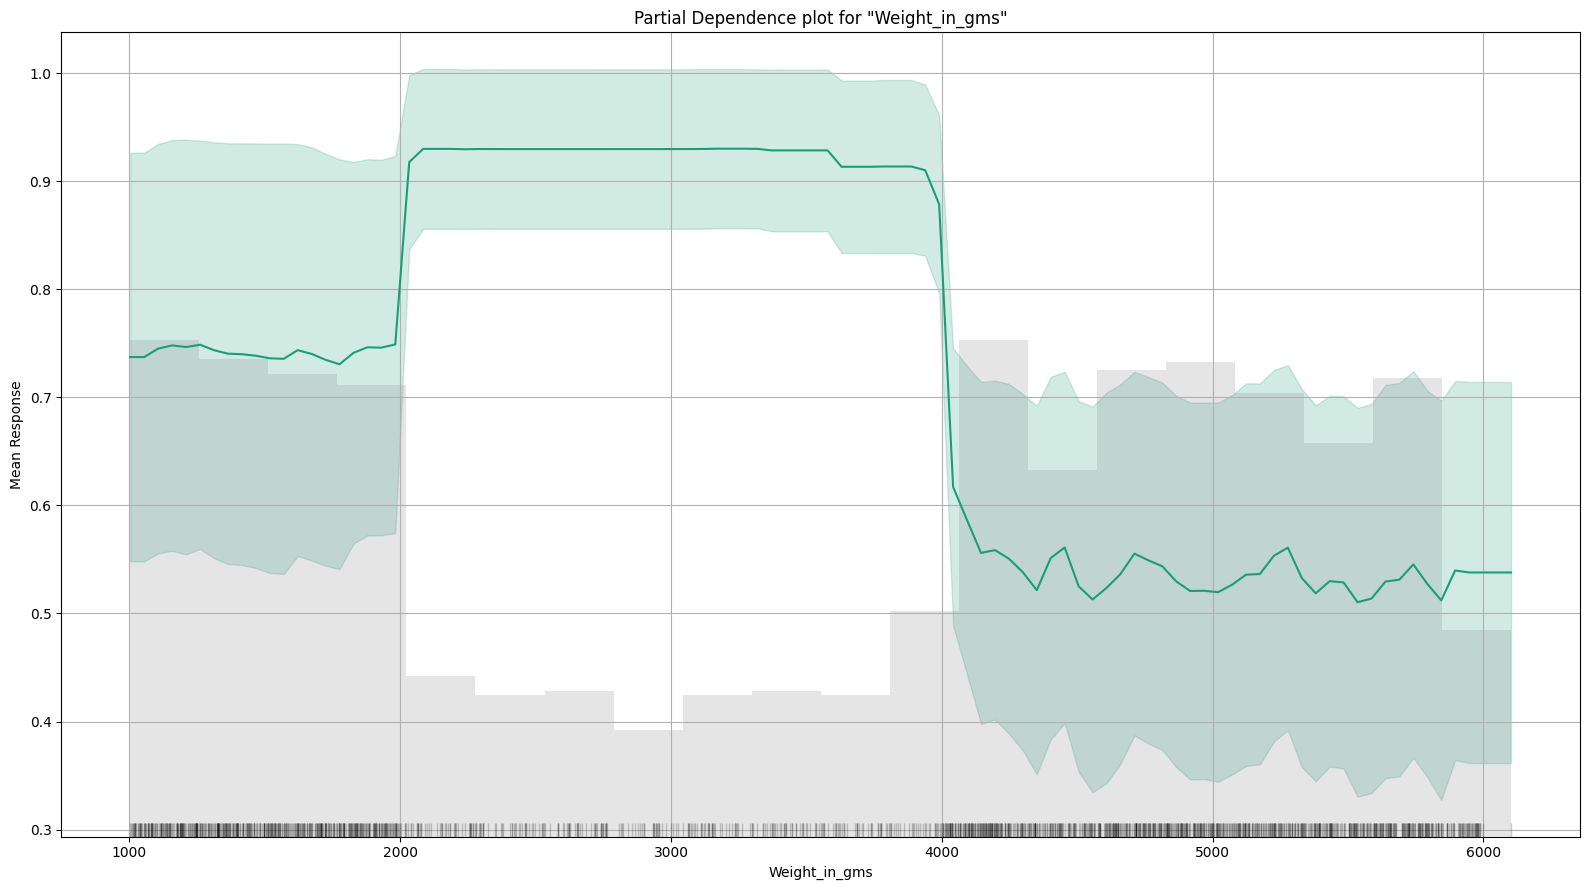

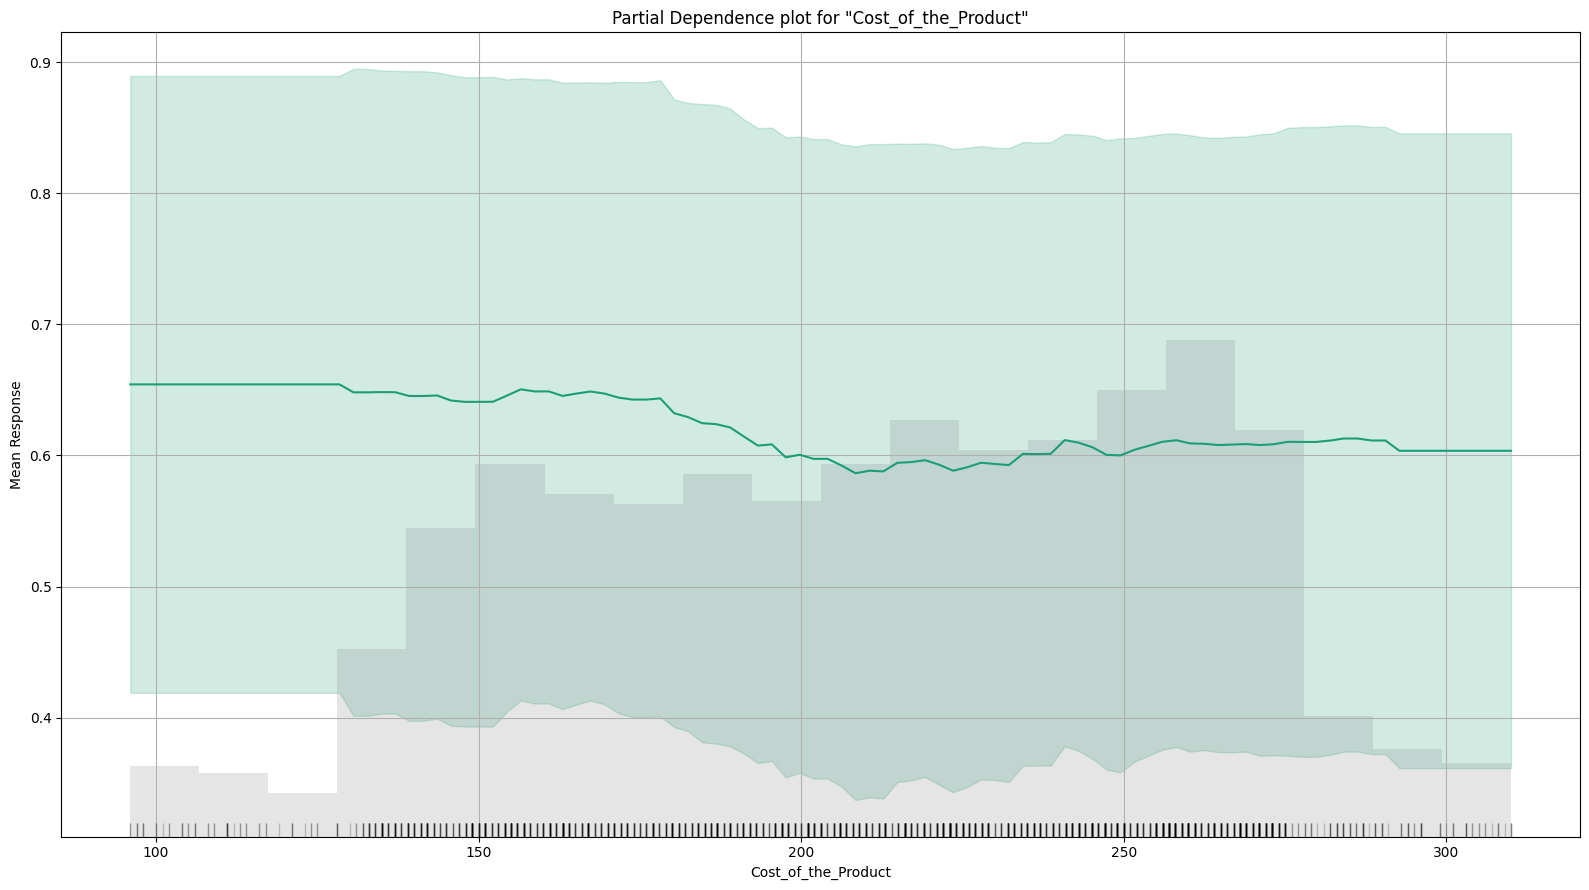

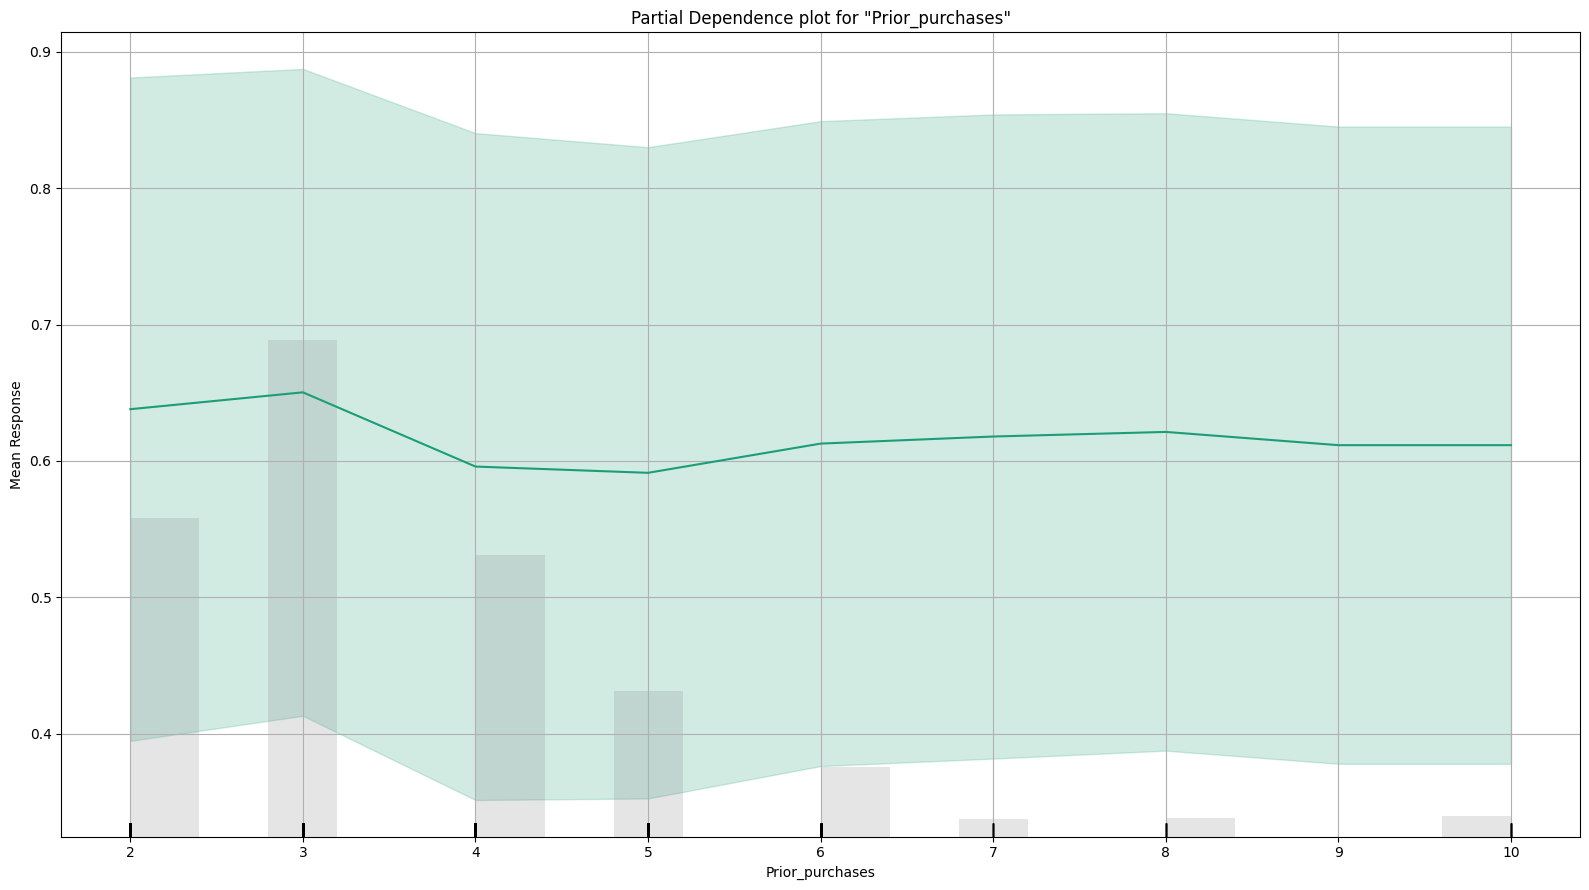

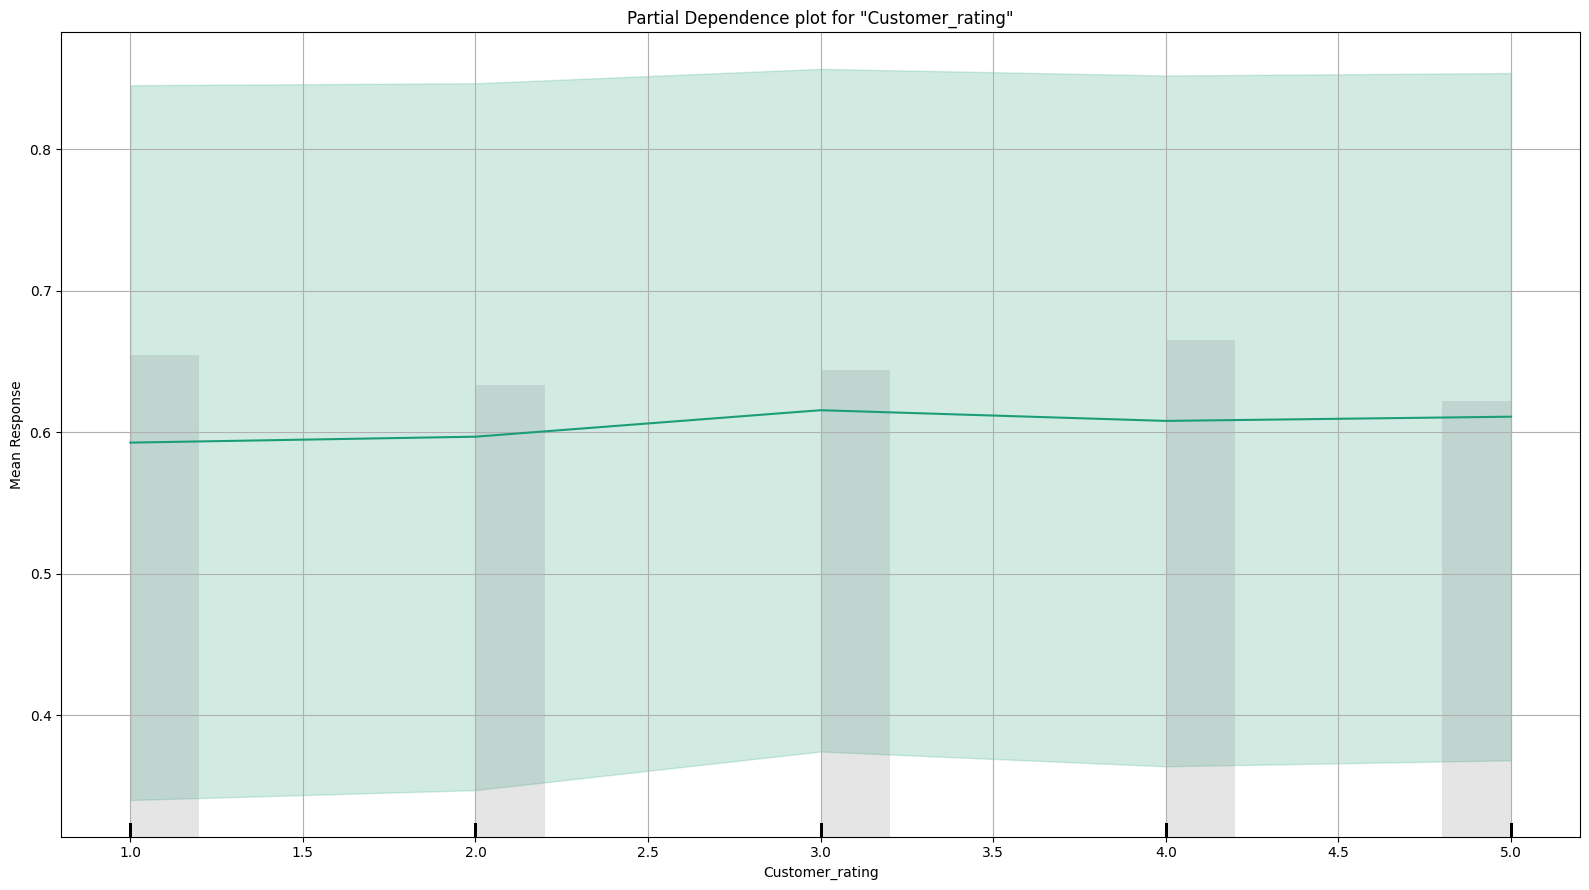

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

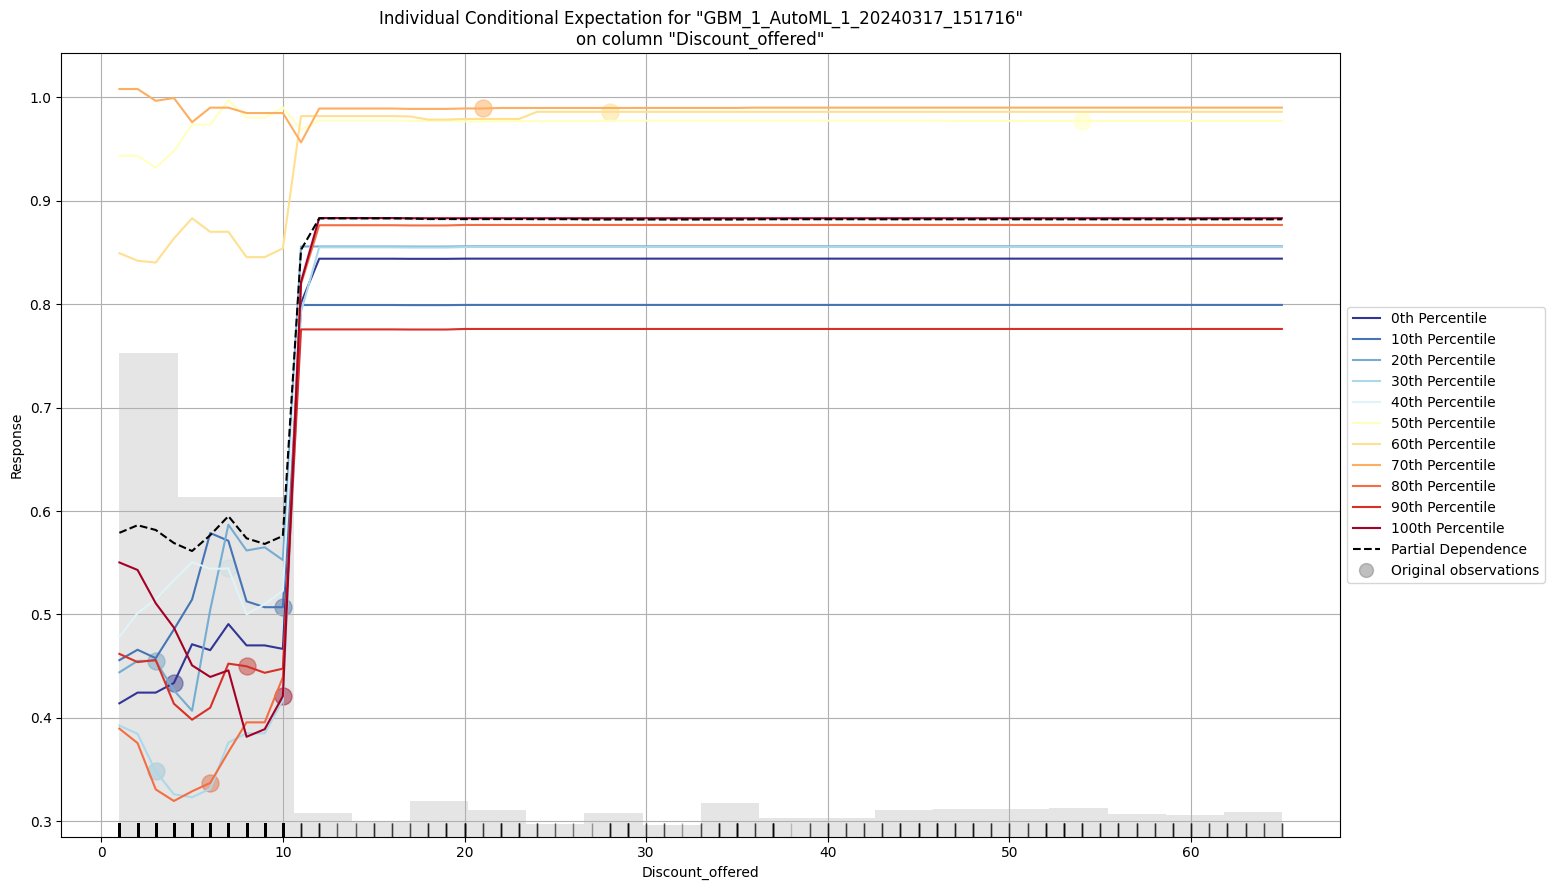

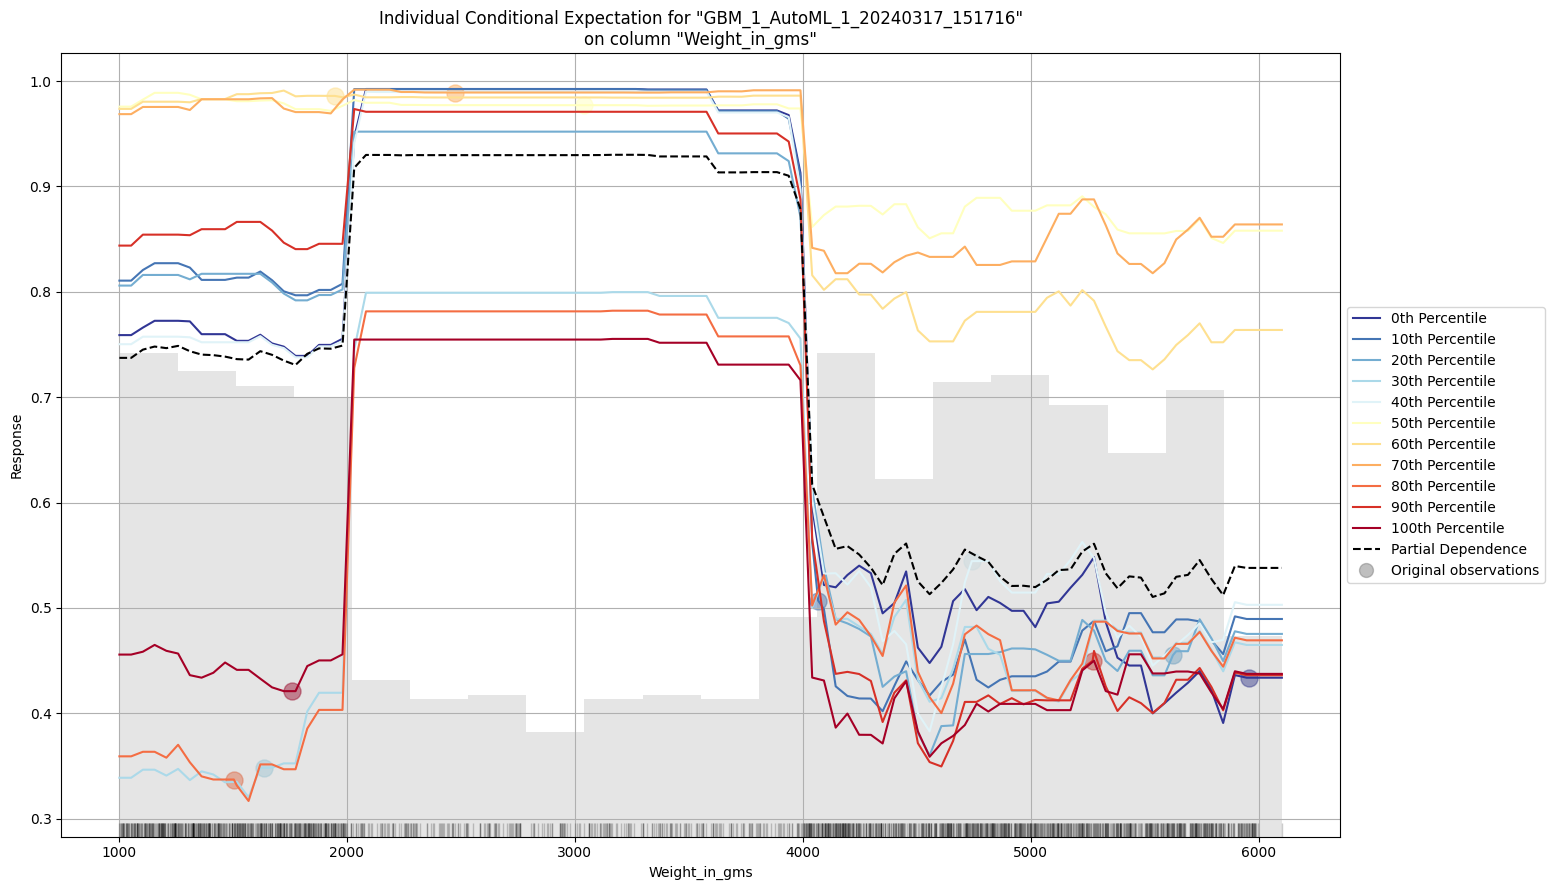

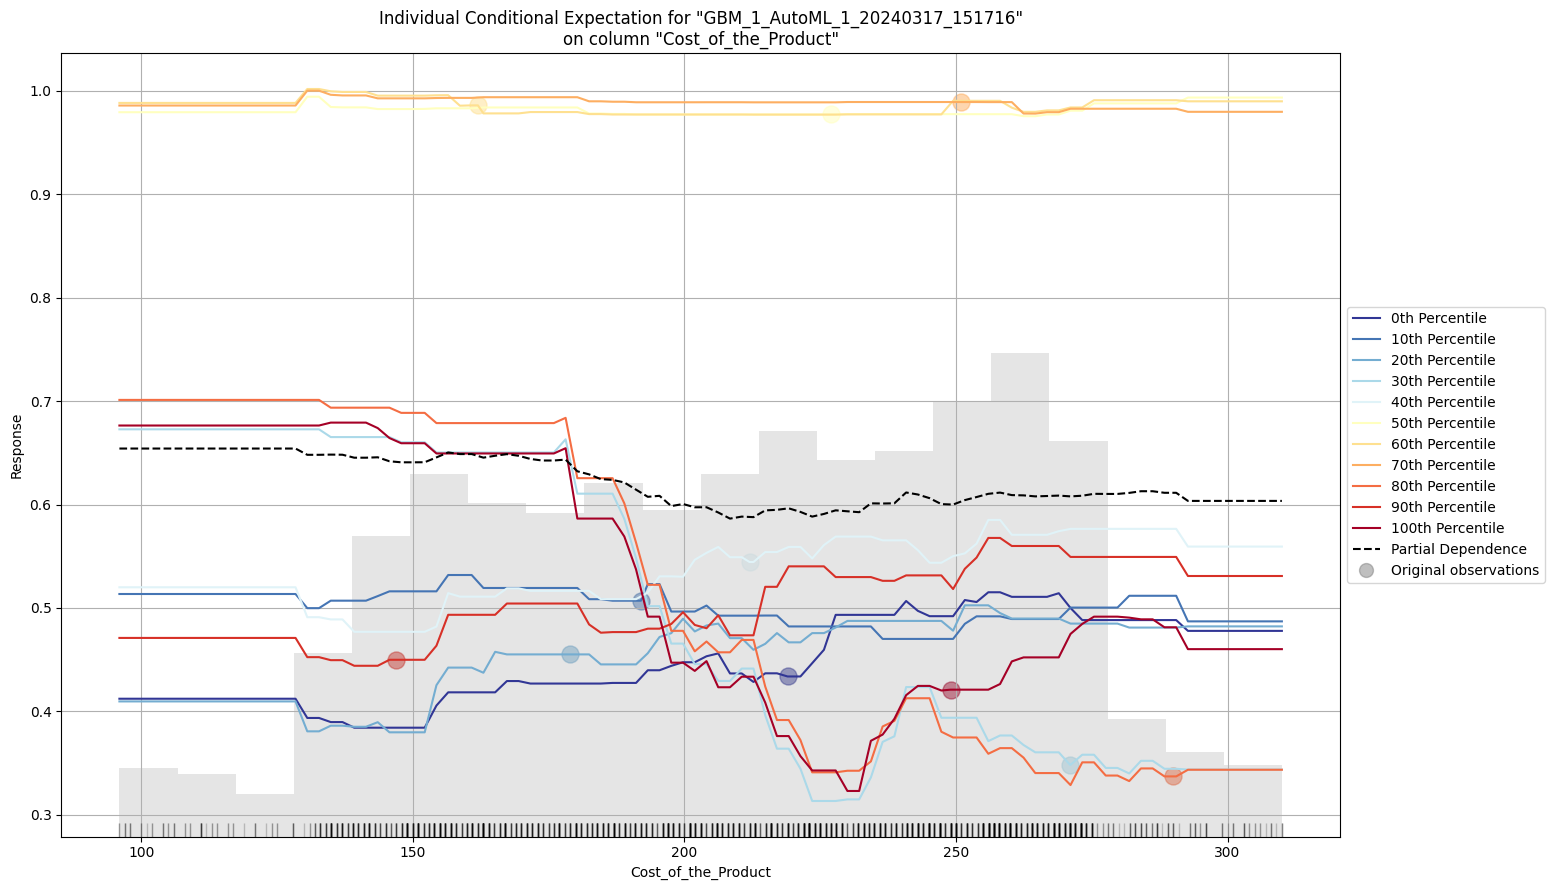

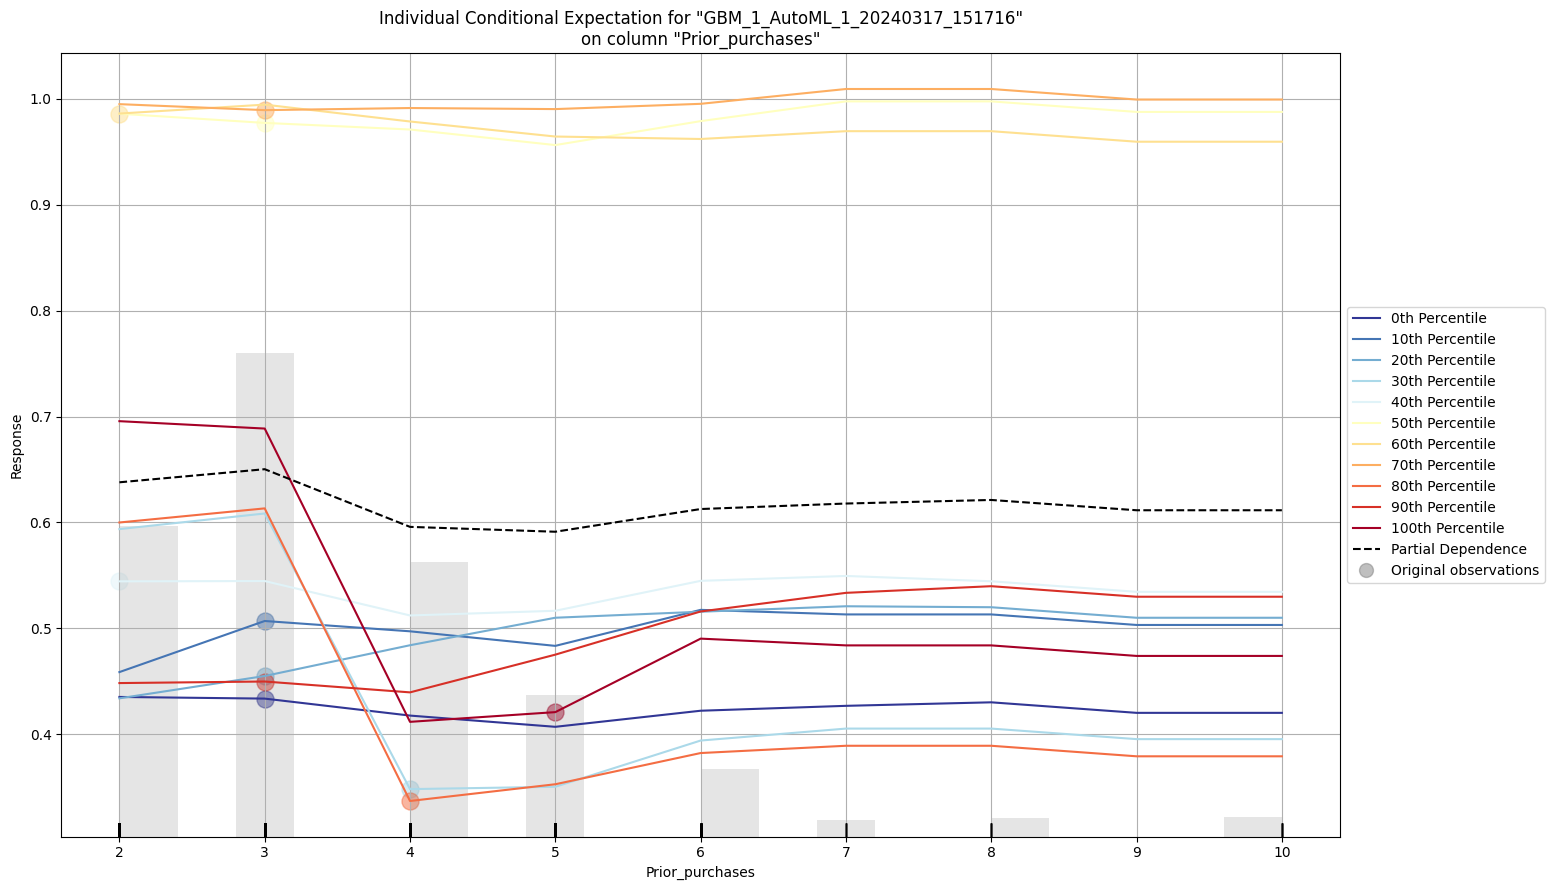

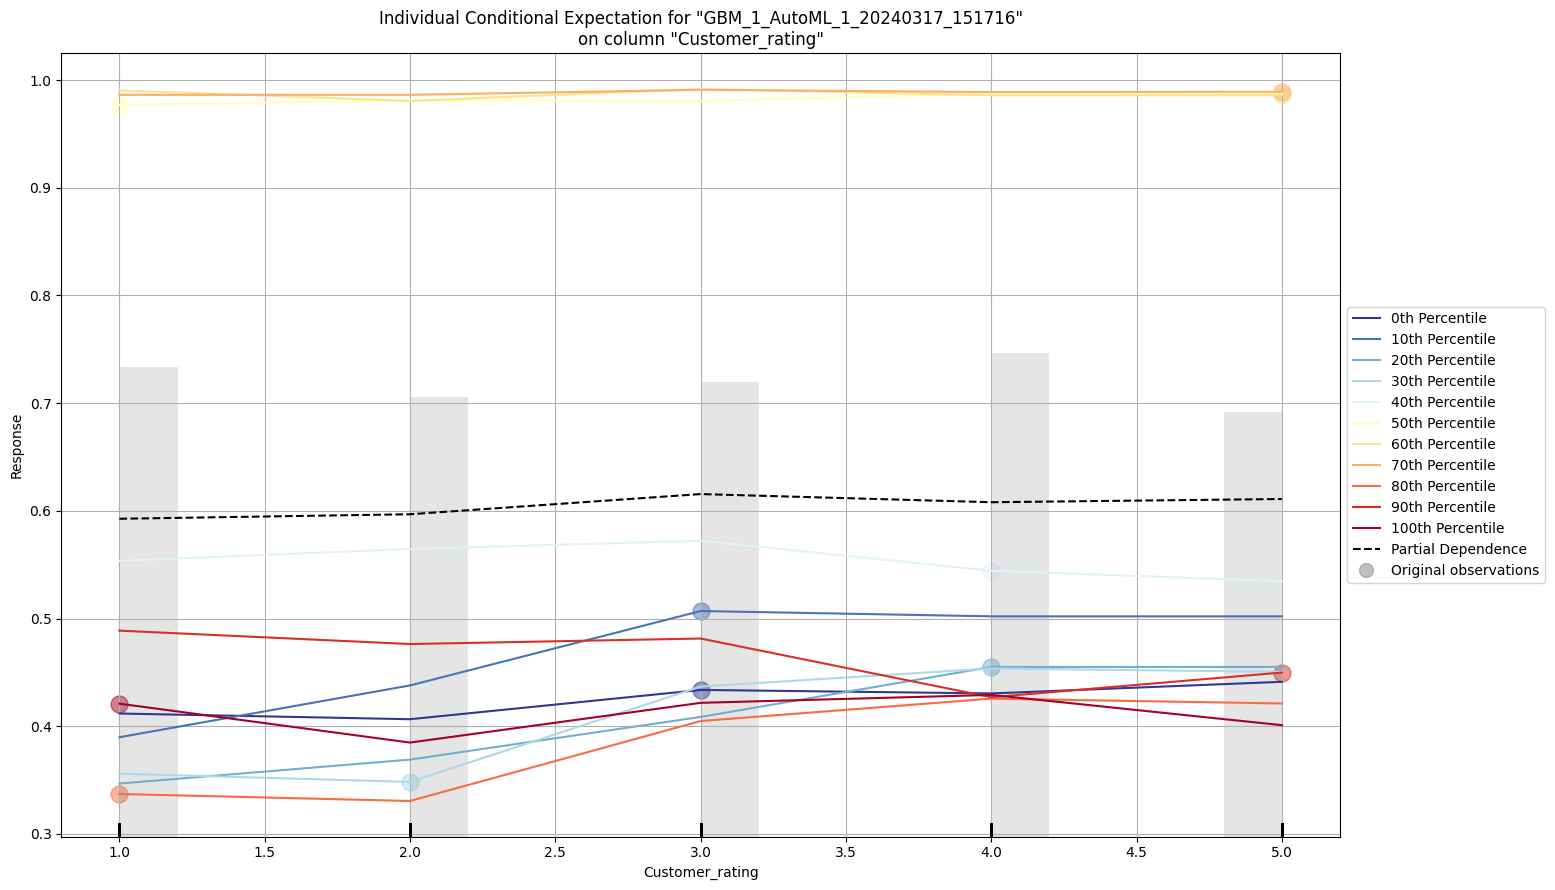

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

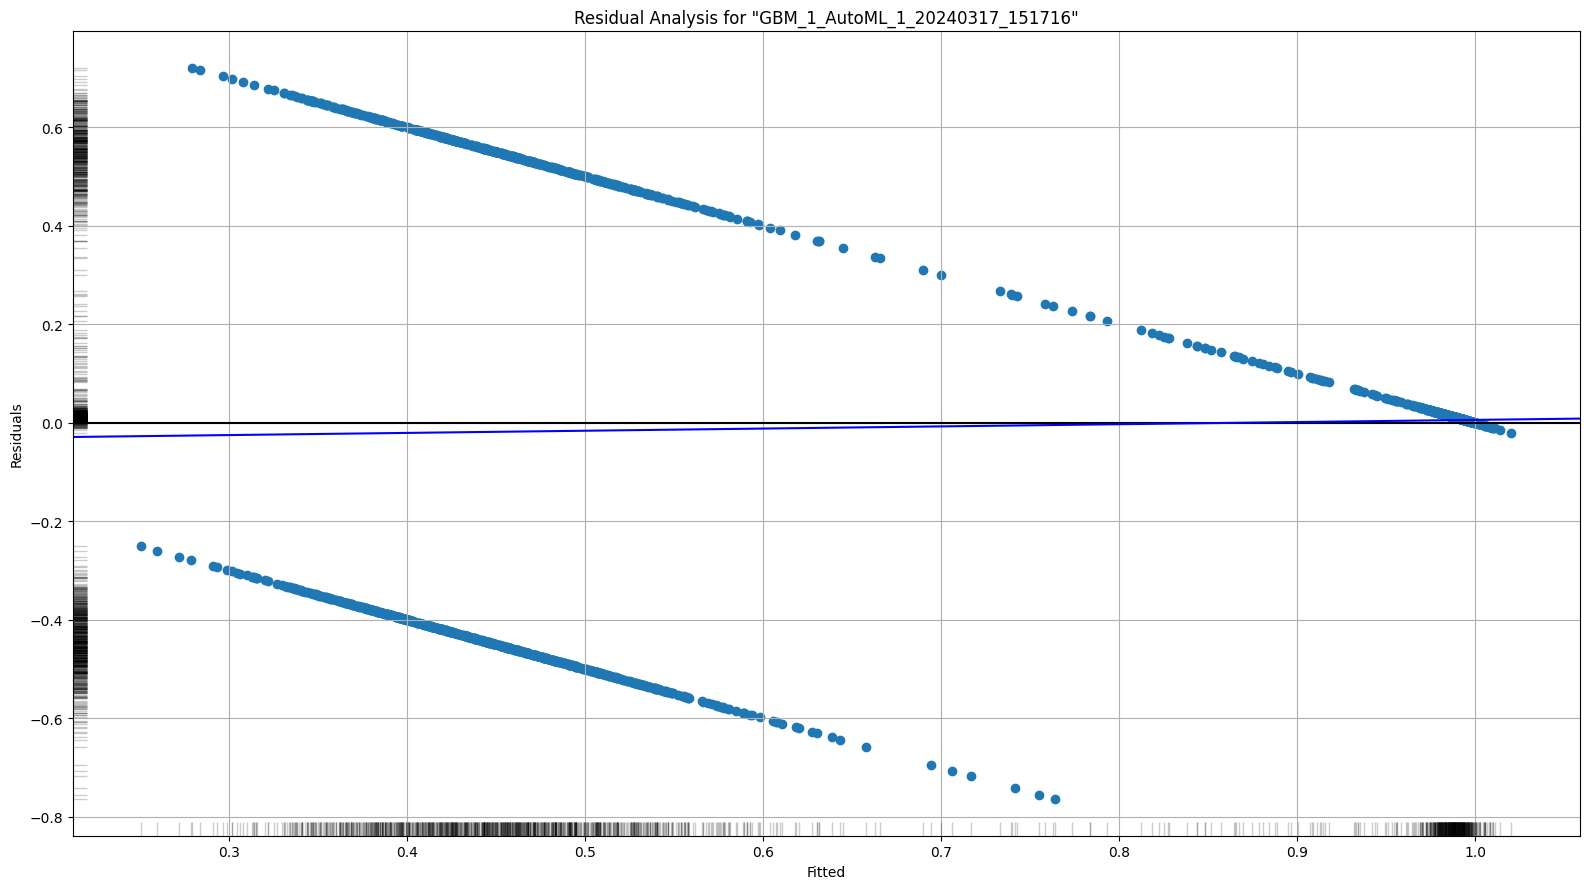

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

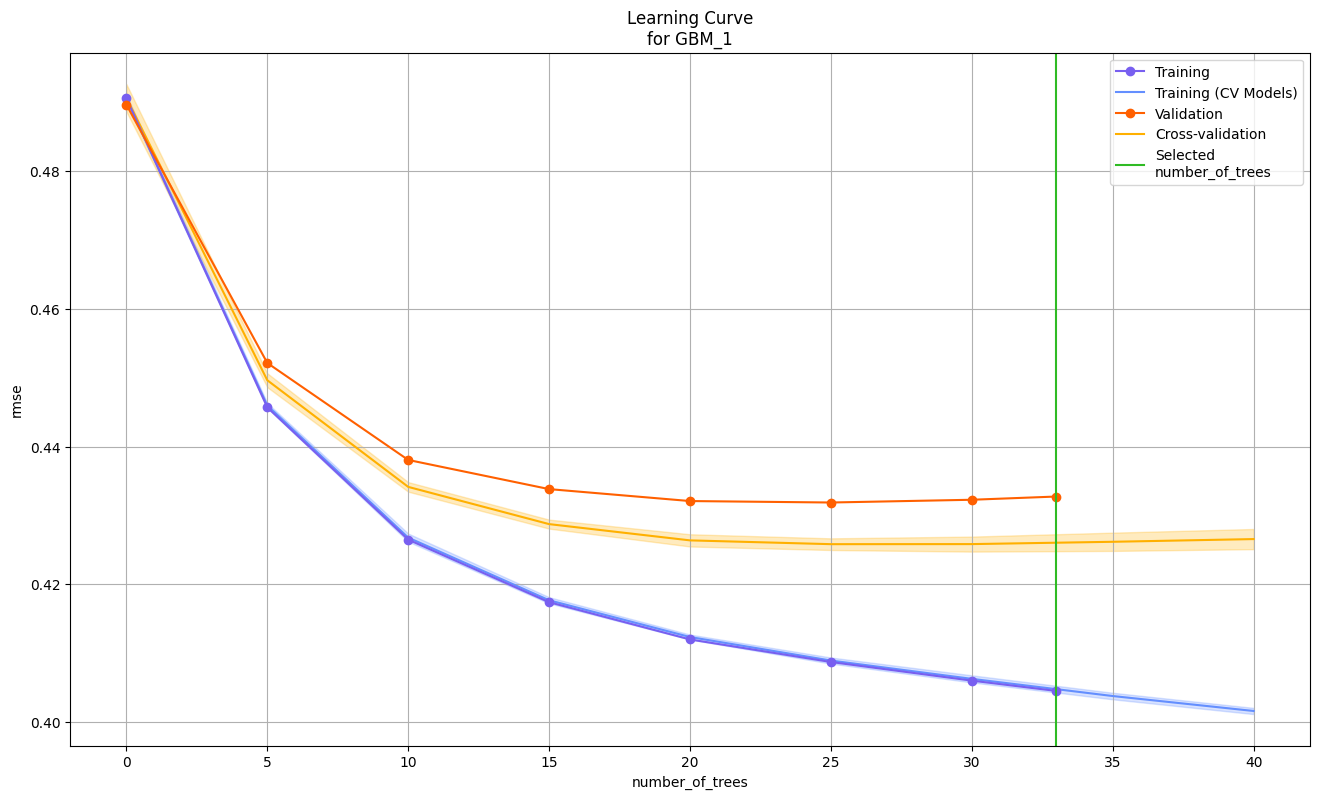

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

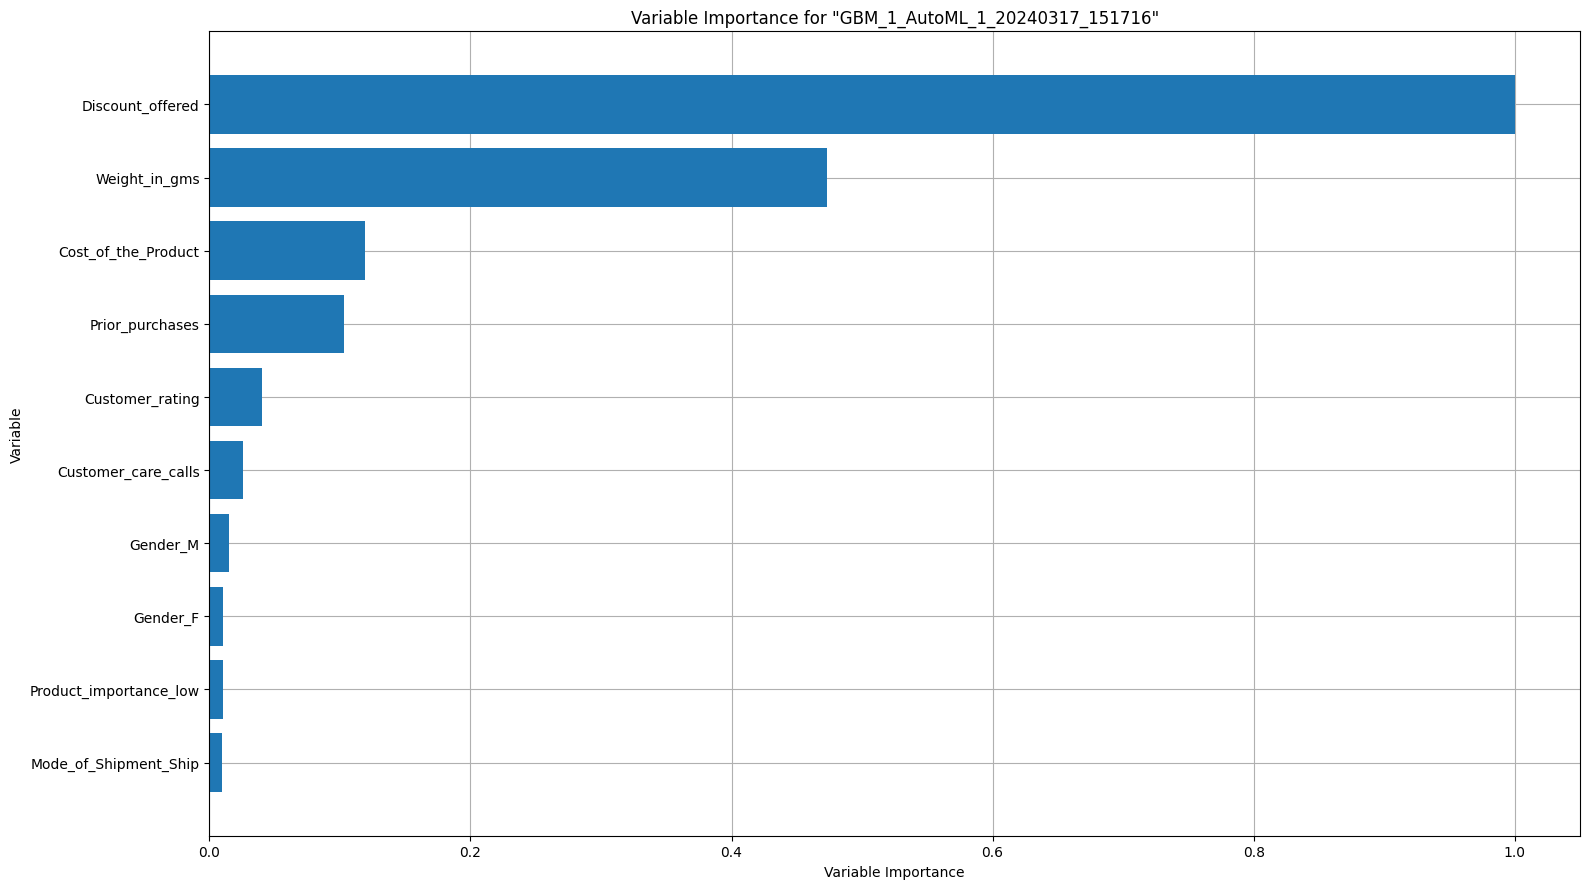

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

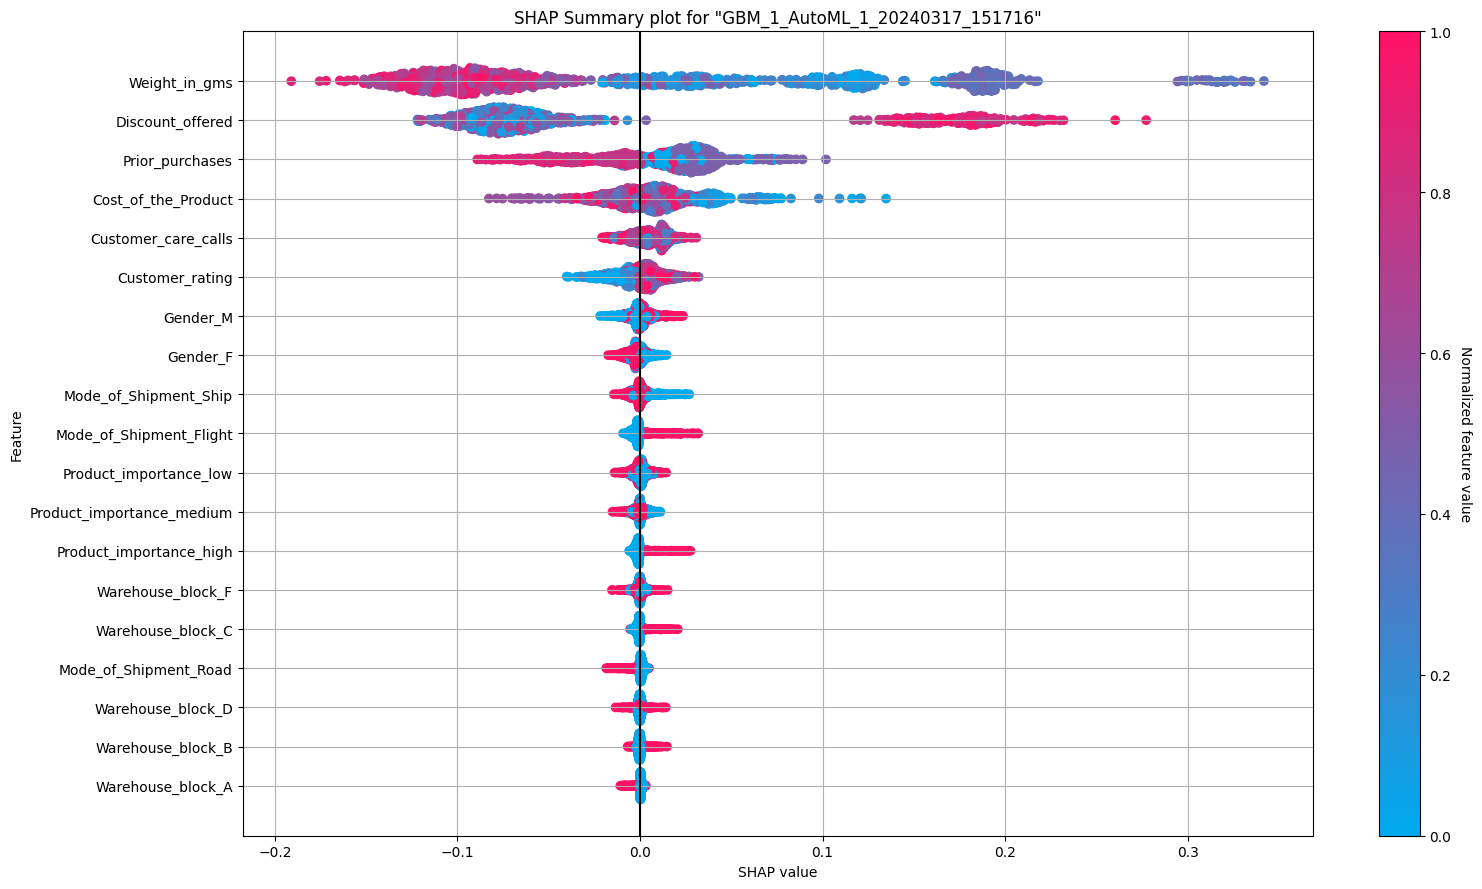

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

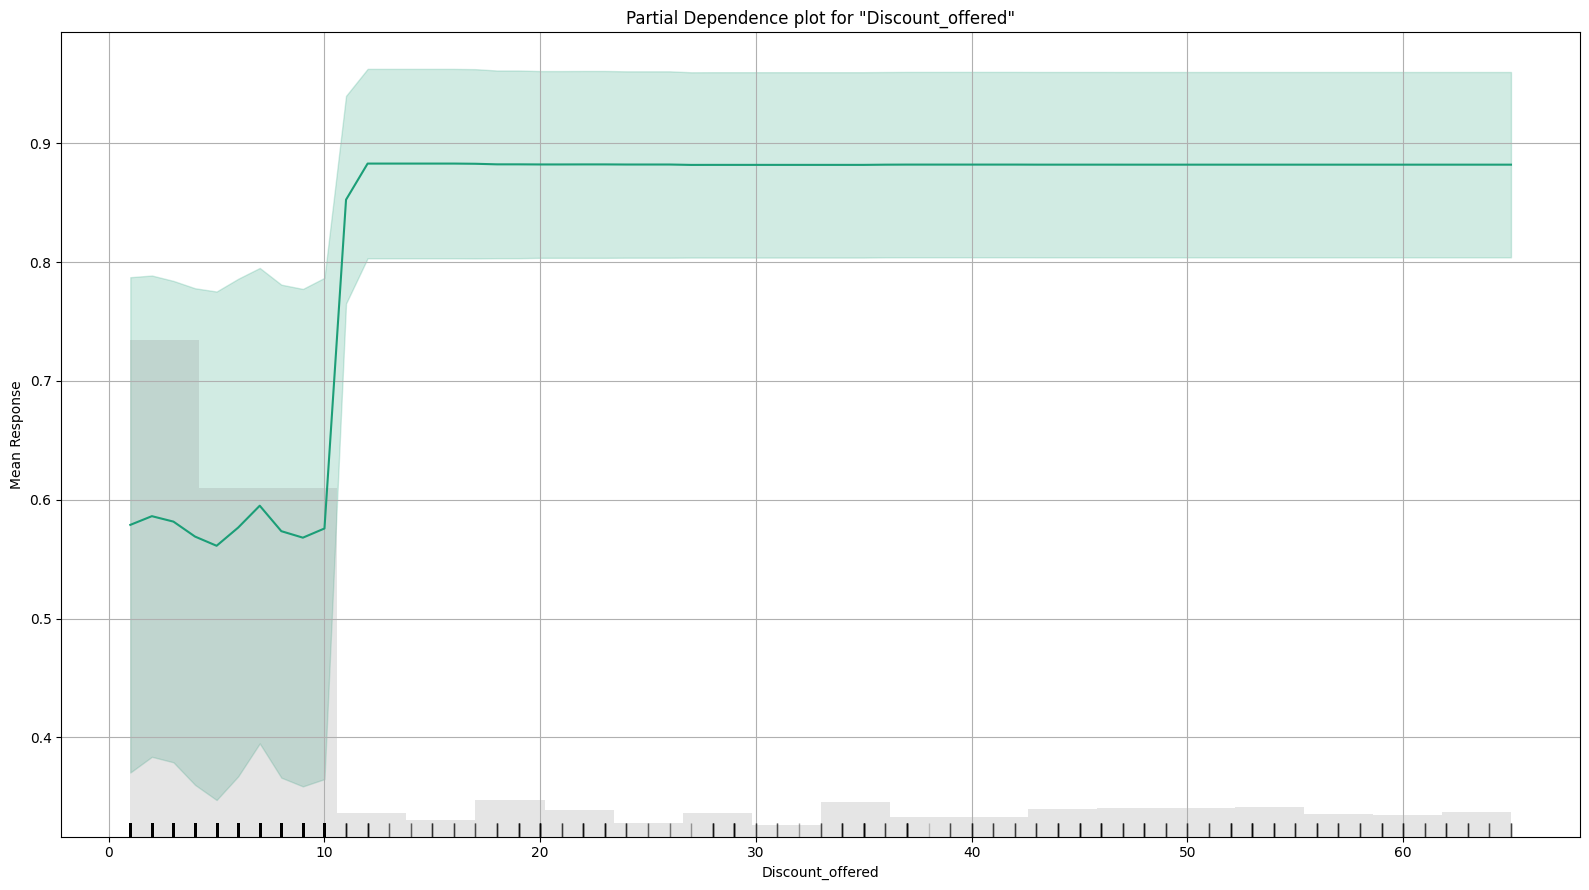

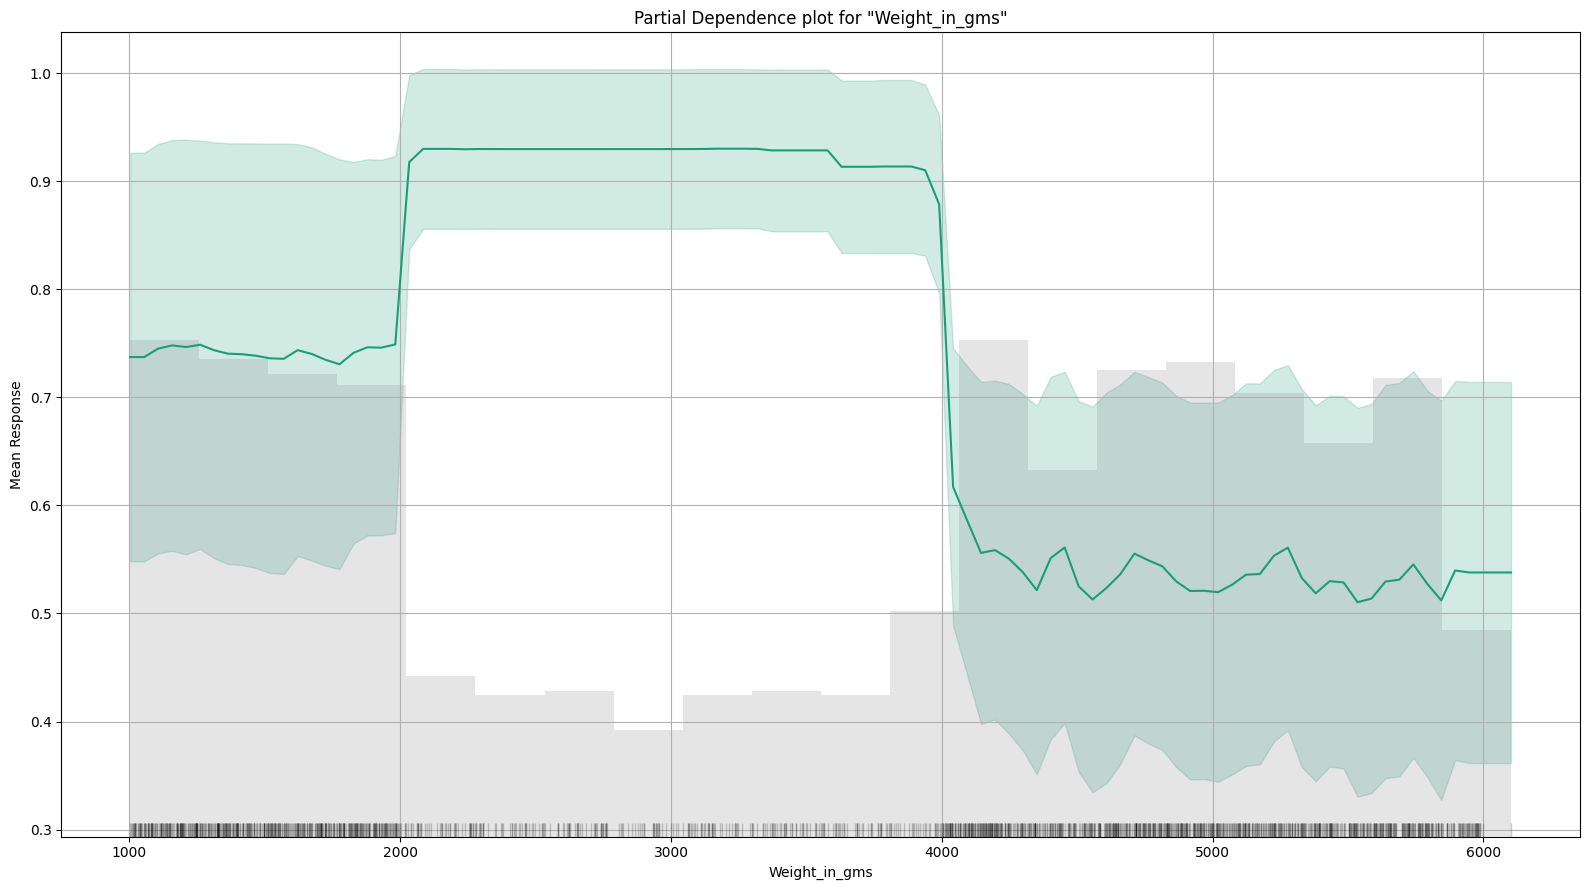

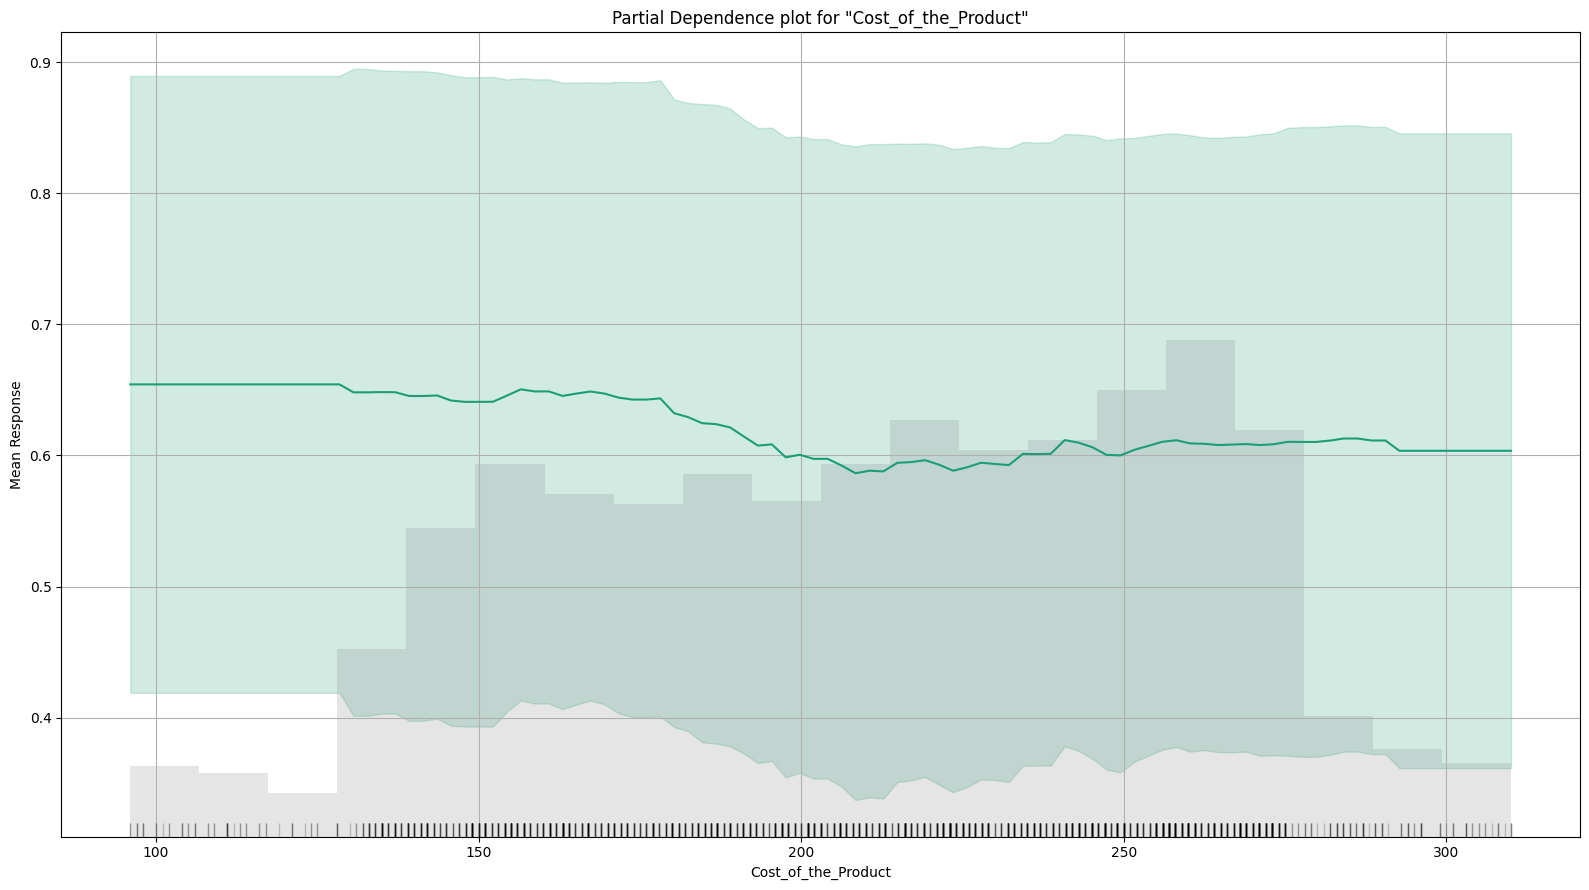

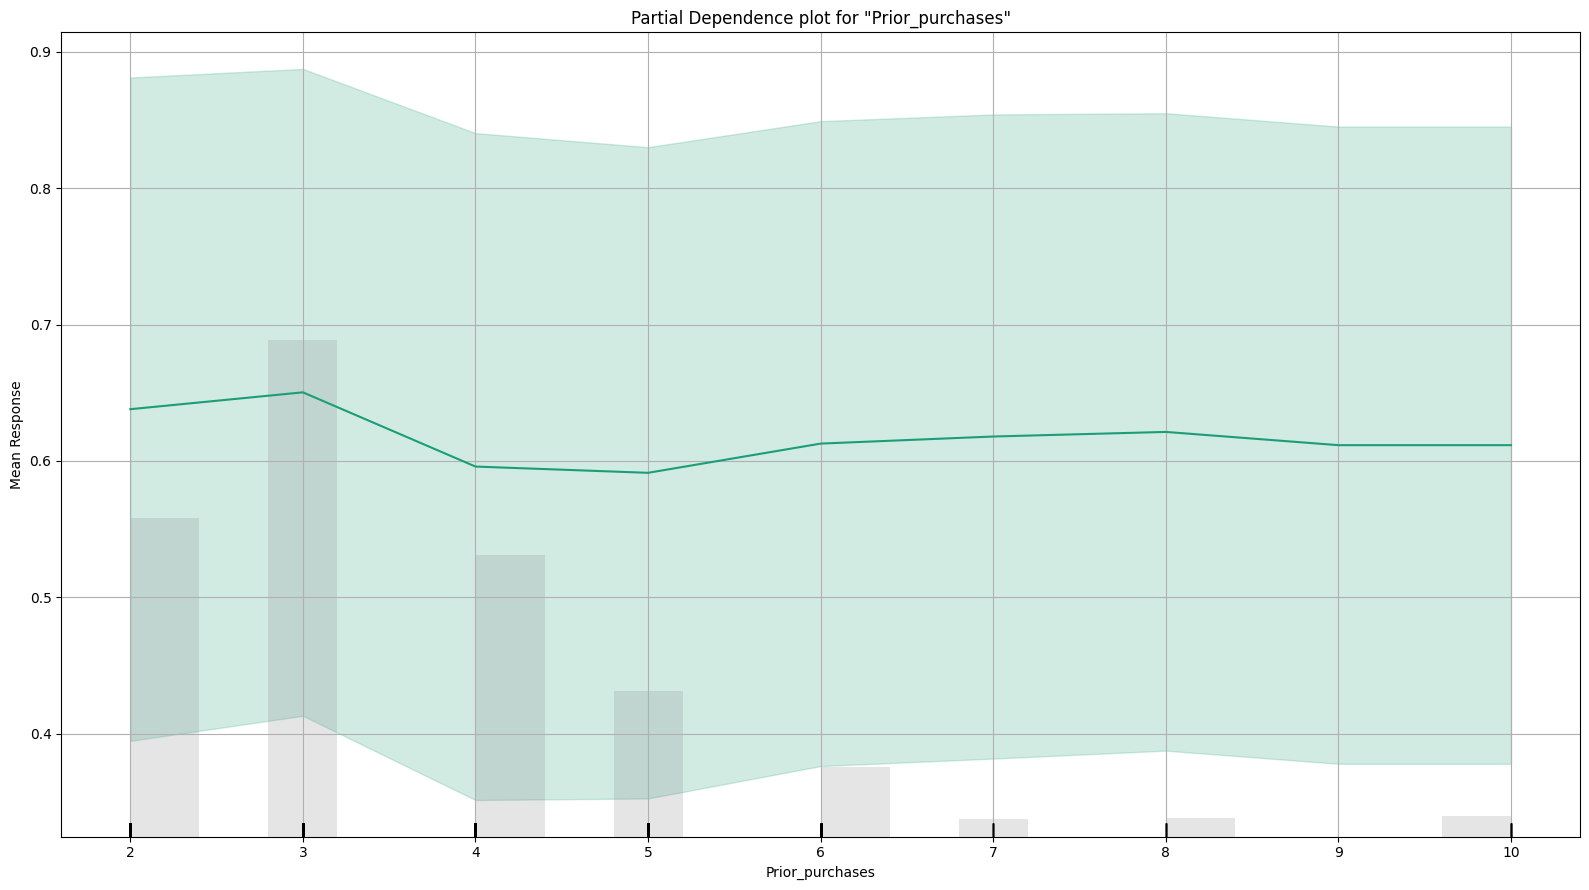

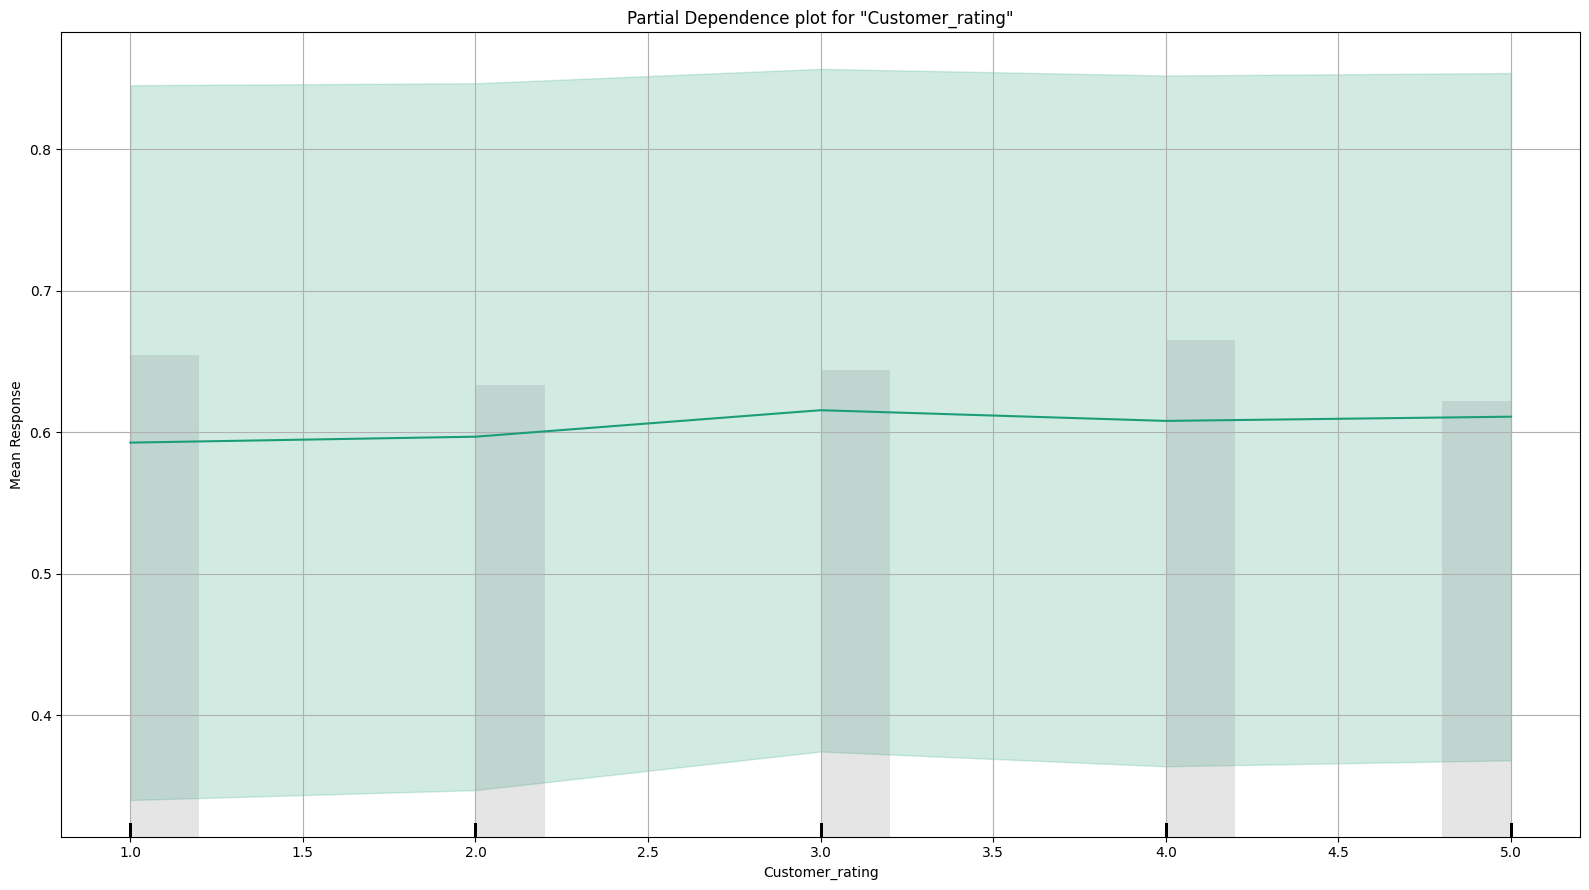

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

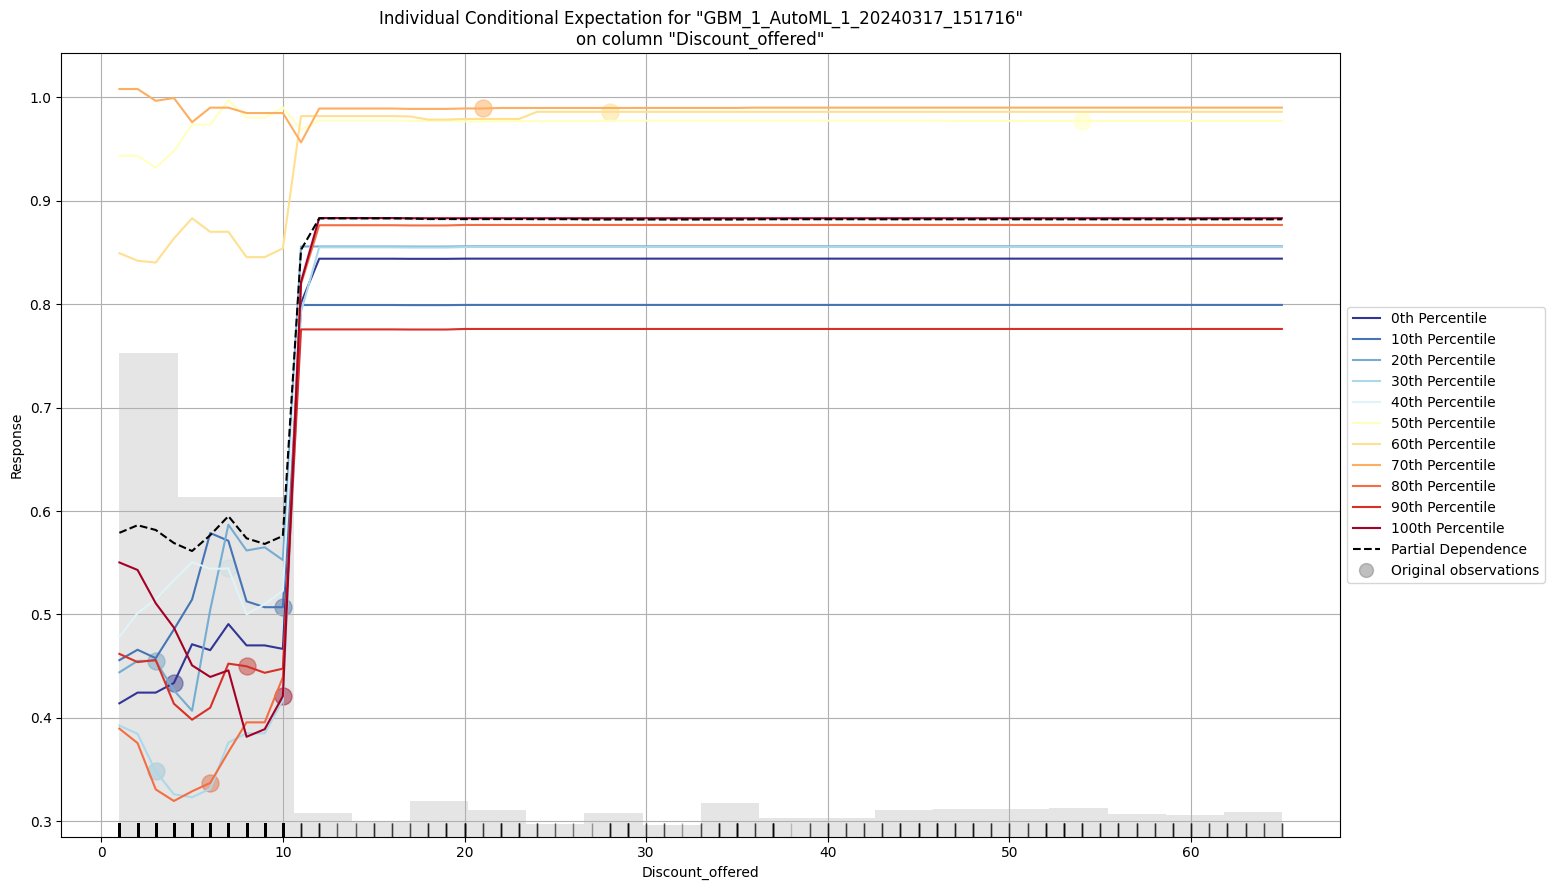

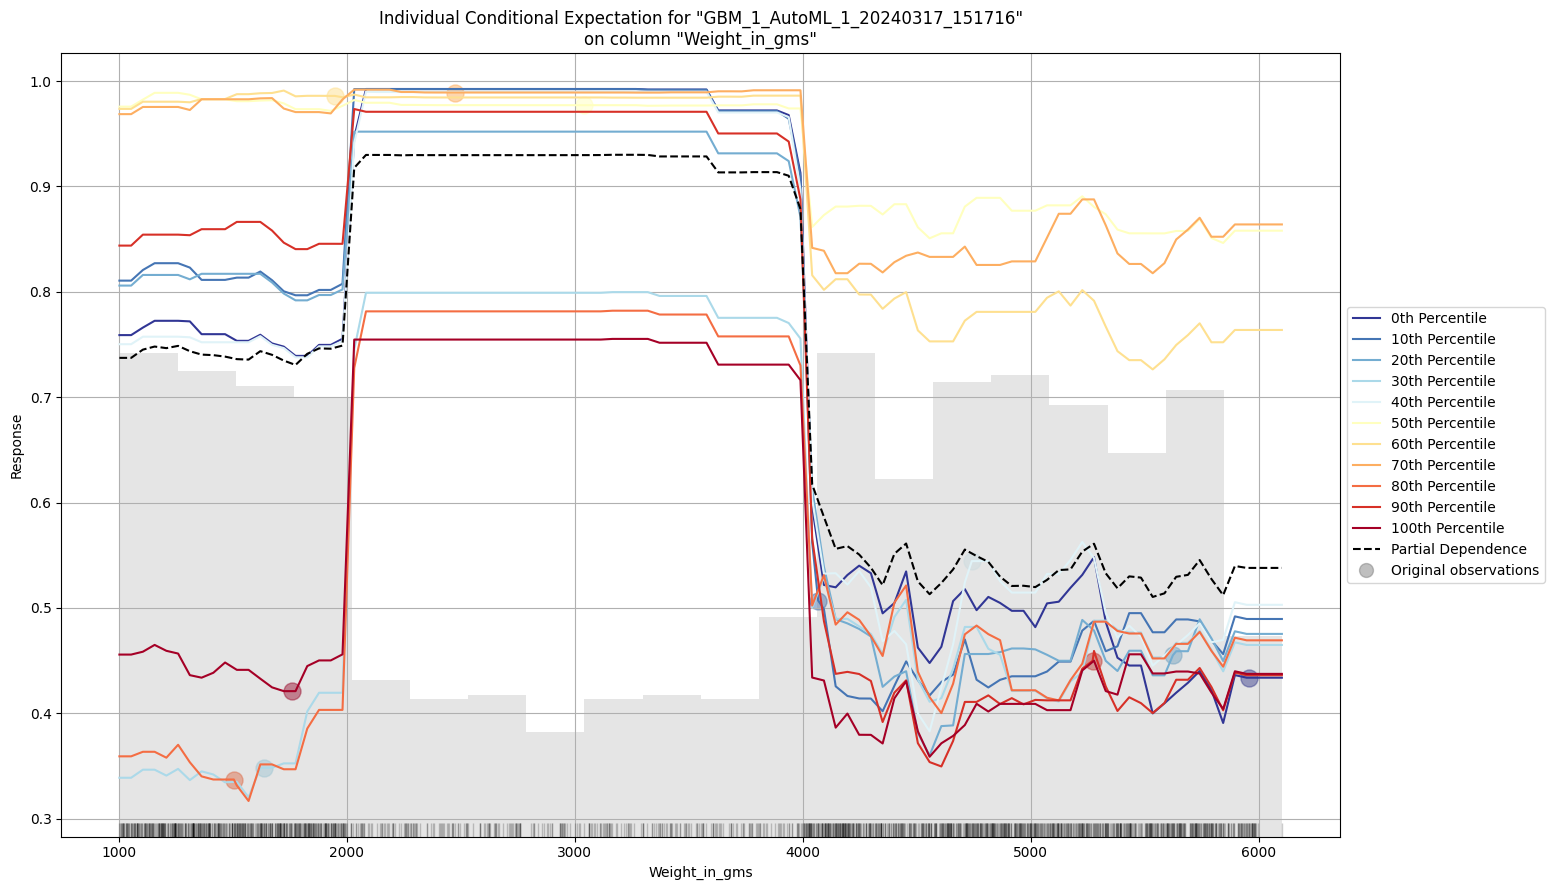

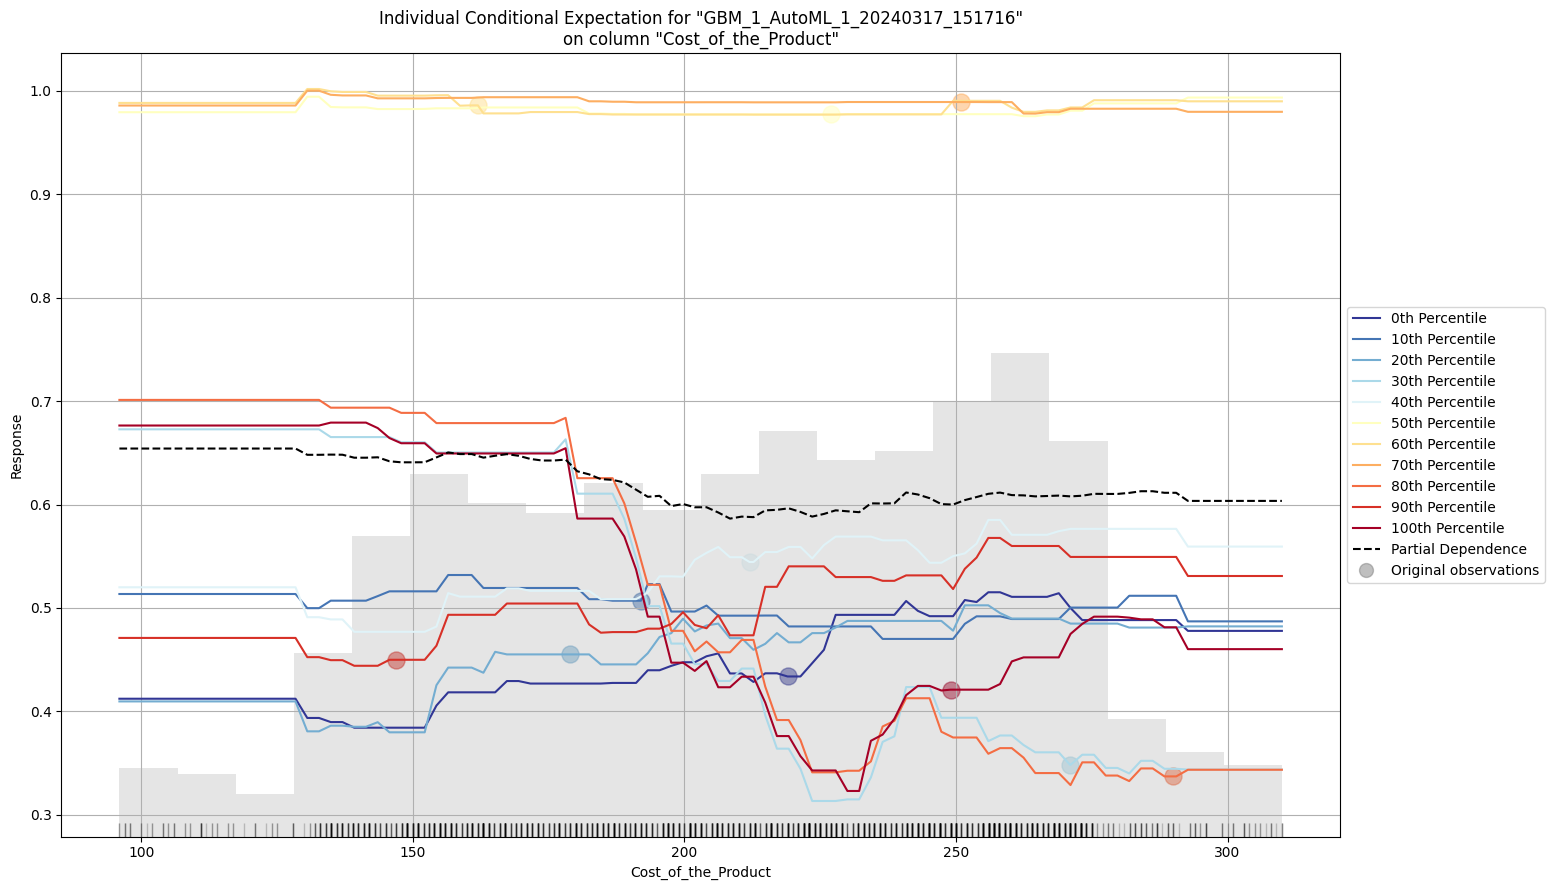

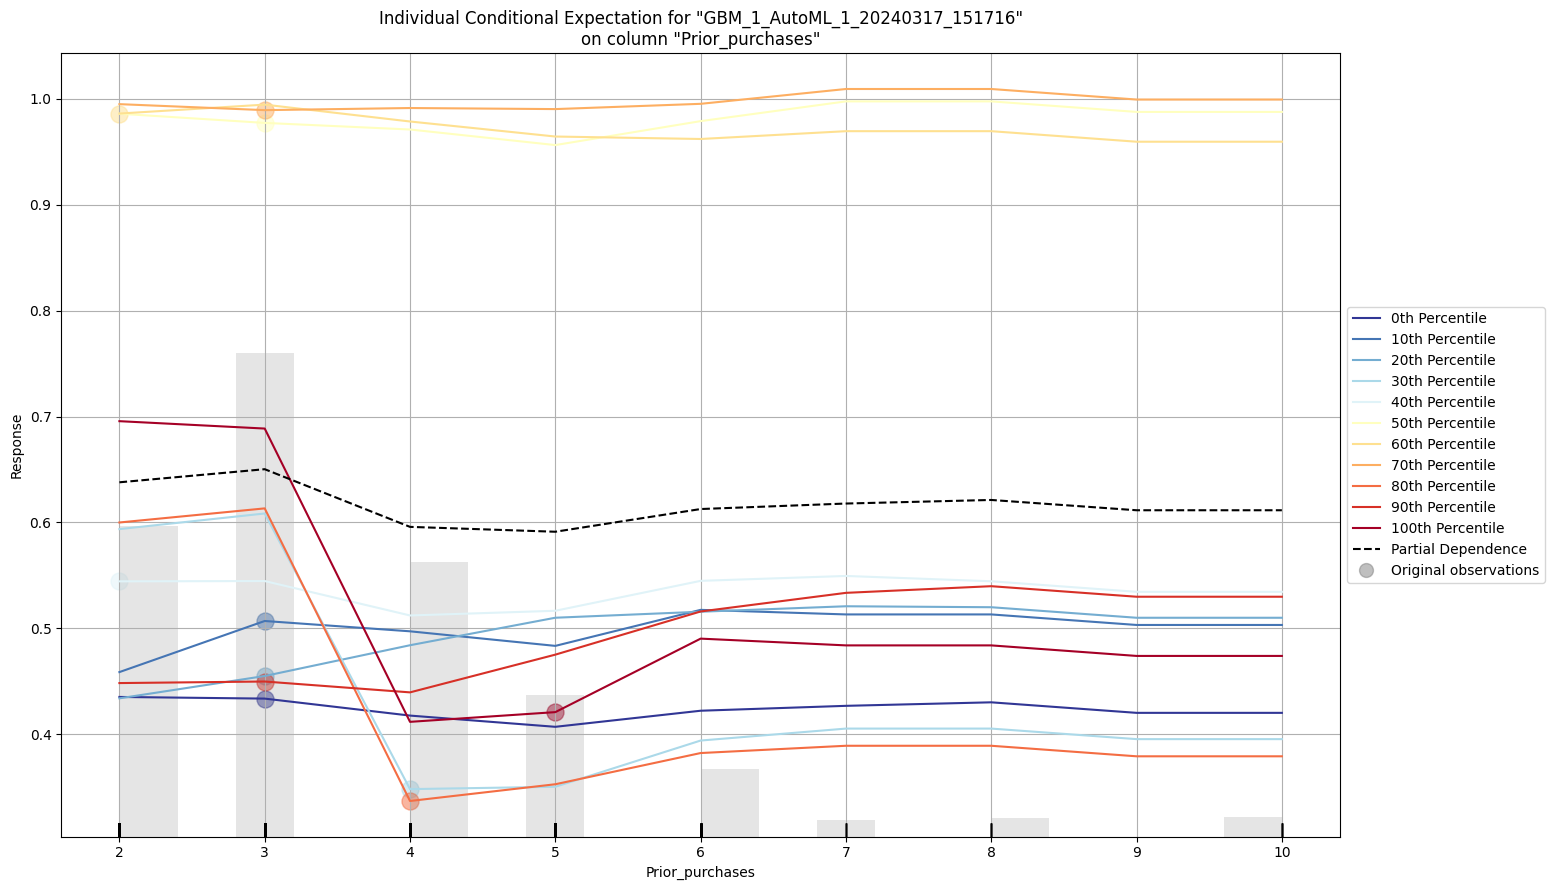

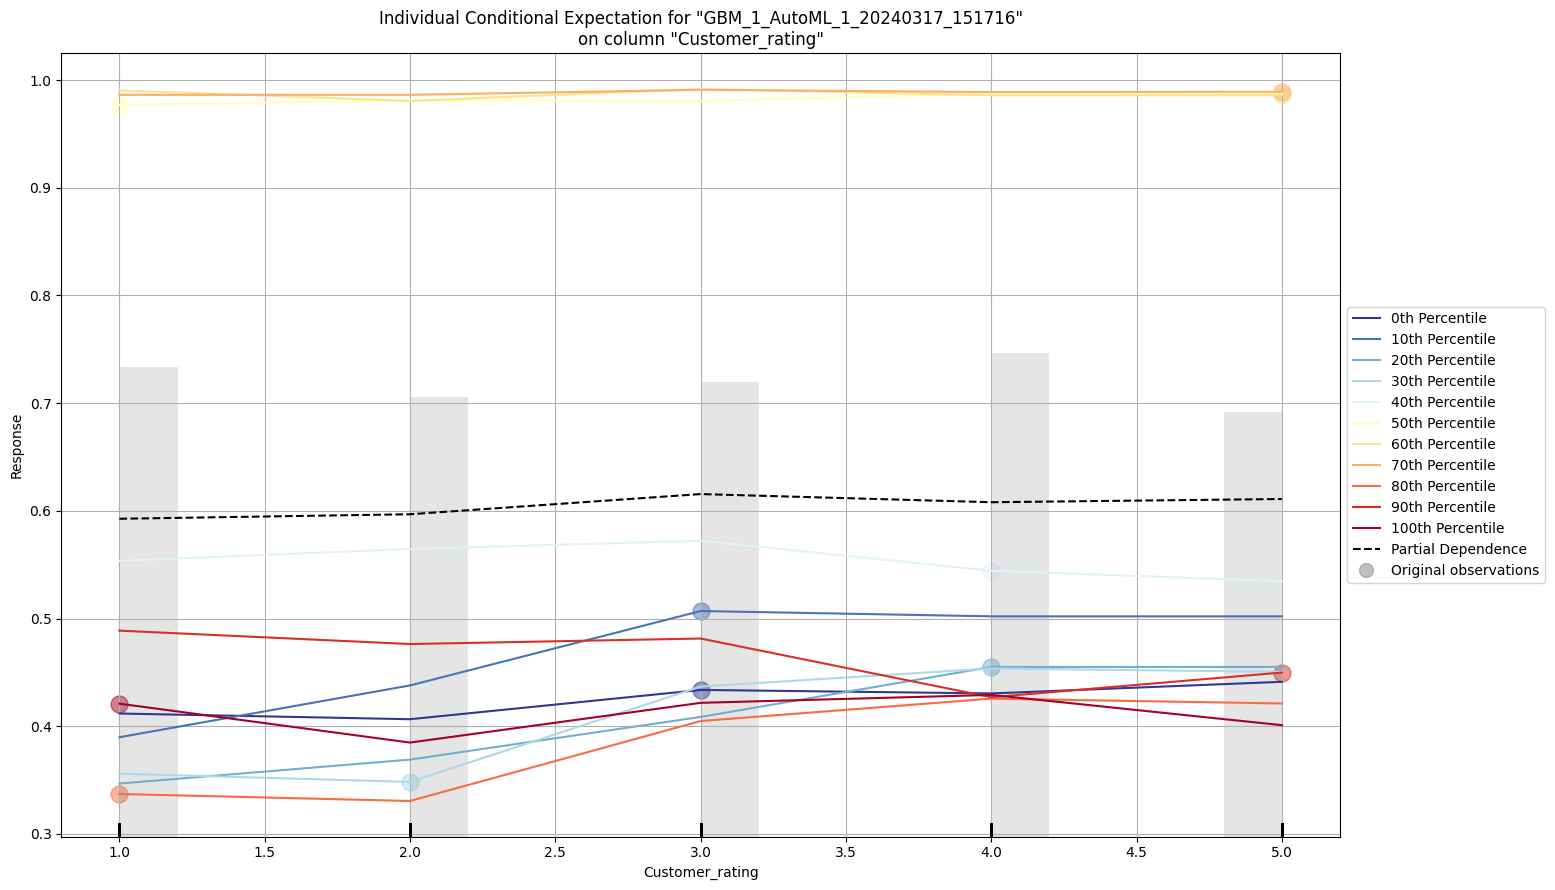

In [87]:
aml.leader.explain(test)

# Reference

1.Scikit learn official documentation

2.Dataset from kaggle by PRACHI GOPALANI

3.Code Reference from [SHAP values](https://github.com/aiskunks/YouTube/blob/main/A_Crash_Course_in_Statistical_Learning/AutoML/AutoML_Smoke_Detection_Example.ipynb) colab notebook.


# Conclusion

We have observed from shap plots and shap values the importance of each feature on the model prediction.

# License

MIT License

Copyright (c) 2024 Vinay Chelpuri

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.